# Similar Words

In [143]:
import pandas as pd
import jieba, re

csvfile = '/Users/hang.xiang/Desktop/sqlResult_1558435.csv'
content = pd.read_csv(csvfile, delimiter=",", quotechar='"', escapechar='\\')
content.fillna('')
news_content = content['content'].dropna().tolist()

In [137]:
def cut(s): return ' '.join(jieba.cut(s))
def token(s): return re.findall(r'[\d|\w]+', s)

In [144]:
import numpy as np
rawdata = [cut(' '.join(token(news))) for news in news_content]

rawdata[:2]

['此外   自 本周   6 月 12 日   起   除 小米 手机 6 等 15 款 机型 外   其余 机型 已 暂停 更新 发布   含 开发 版   体验版 内测   稳定版 暂不受 影响   以 确保 工程师 可以 集中 全部 精力 进行 系统优化 工作   有人 猜测 这 也 是 将 精力 主要 用到 MIUI   9 的 研发 之中   MIUI   8 去年 5 月 发布   距今已有 一年 有余   也 是 时候 更新换代 了   当然   关于 MIUI   9 的 确切 信息   我们 还是 等待 官方消息',
 '骁龙 835 作为 唯一 通过 Windows   10 桌面 平台 认证 的 ARM 处理器   高通 强调   不会 因为 只 考虑 性能 而 去 屏蔽掉 小 核心   相反   他们 正 联手 微软   找到 一种 适合 桌面 平台 的   兼顾 性能 和 功耗 的 完美 方案   报道 称   微软 已经 拿到 了 一些 新 的 源码   以便 Windows   10 更好 地 理解 big   little 架构   资料 显示   骁龙 835 作为 一款 集成 了 CPU   GPU   基带   蓝牙   Wi   Fi 的 SoC   比 传统 的 Wintel 方案 可以 节省 至少 30   的 PCB 空间   按计划   今年 Q4   华硕   惠普   联想 将 首发 骁龙 835   Win10 电脑   预计 均 是 二合一 形态 的 产品   当然   高通 骁龙 只是 个 开始   未来 也许 还 能 见到 三星 Exynos   联发科   华为 麒麟   小米 澎湃 等 进入 Windows   10 桌面 平台']

In [4]:
with open('news-sentences-cut.txt', 'w') as f:
    f.writelines(rawdata)

In [5]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

In [6]:
news_word2ve= Word2Vec(LineSentence('news-sentences-cut.txt'), size=35, workers=8)

In [7]:
news_word2ve.most_similar('表示')

/Users/hang.xiang/Desktop/MyNLPCourse/venvNLP/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('指出', 0.9098141193389893),
 ('说', 0.89851313829422),
 ('认为', 0.8960184454917908),
 ('强调', 0.8137581944465637),
 ('透露', 0.7904095649719238),
 ('称', 0.7799001932144165),
 ('坦言', 0.7778766751289368),
 ('看来', 0.7765998840332031),
 ('介绍', 0.7179794311523438),
 ('建议', 0.7091478109359741)]

# More Data Better Result
1. 分词的问题
2. 数据量，量越多结果越准确

In [8]:
from collections import defaultdict

def getRelatedWords(iniwords, model):
    unseen = iniwords
    seen = defaultdict(int)
    max_size = 500
    
    while unseen and len(seen) < max_size:
        node = unseen.pop(0)
        new_expanding = [w for w,s in model.most_similar(node, topn=20)]
        unseen += new_expanding
        seen[node] += 1
        
    return seen

In [9]:
related_words = getRelatedWords(['说','表示'], news_word2ve)
sorted_related_words = sorted(related_words.items(), key=lambda x: x[1], reverse=True)
sorted_related_words[:20]

/Users/hang.xiang/Desktop/MyNLPCourse/venvNLP/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # Remove the CWD from sys.path while we load stuff.


[('表示', 96),
 ('指出', 91),
 ('说', 77),
 ('透露', 77),
 ('认为', 74),
 ('坦言', 67),
 ('提到', 62),
 ('称', 59),
 ('看来', 55),
 ('强调', 54),
 ('所说', 53),
 ('特别强调', 49),
 ('中说', 44),
 ('介绍', 37),
 ('告诉', 37),
 ('呼吁', 35),
 ('明说', 33),
 ('普遍认为', 33),
 ('建议', 31),
 ('提及', 31)]

# TFIDF words

In [27]:
import math

def word_frequency(word, documents=rawdata):
    return sum([1 for doc in documents if word in doc])

def idf(word, documents=rawdata):
    return math.log10(len(documents) / word_frequency(word, documents))

def tf(word, doc):
    return doc.count(word)

def get_key_word_in_docment(doc):
    words = set(doc.split())
    tfidf = [(w, tf(w, doc)*idf(w)) for w in words]
    tfidf.sort(key=lambda x:x[1], reverse=True)
    return tfidf

In [13]:
word_frequency("的", rawdata)

70342

In [15]:
print(idf("小米", rawdata), idf("美的", rawdata))

2.9354673573055914 2.704260284180685


In [22]:
tf("A股", rawdata[5])

8

In [28]:
get_key_word_in_docment(rawdata[101])

[('残疾', 18.25421867544897),
 ('拜城县', 17.850669905474287),
 ('残疾人', 16.930554531689385),
 ('技能', 12.256270367272883),
 ('培训', 10.00072475414698),
 ('班', 8.727380156747637),
 ('雕刻', 8.660130862814443),
 ('培训基地', 6.32327496140918),
 ('学习', 5.780310823531885),
 ('培训班', 5.37873745755868),
 ('就业', 5.105227883878316),
 ('吕丽娜', 4.939788731088234),
 ('乡亚吐尔村', 4.939788731088234),
 ('阿不都热依木', 4.939788731088234),
 ('全县', 4.84782977475311),
 ('能', 4.847508687885512),
 ('本站', 4.720010268942848),
 ('本文', 4.584811521947229),
 ('收入', 4.570443432085054),
 ('合作社', 4.324723817397845),
 ('内容', 4.268174572816738),
 ('托乎', 4.036698744096291),
 ('斯坎', 4.036698744096291),
 ('托克逊', 4.036698744096291),
 ('现在', 3.949308148650726),
 ('文字', 3.7991642070270455),
 ('多元', 3.710424906307806),
 ('亚森', 3.597366050266028),
 ('花纹', 3.5084249669292467),
 ('每个', 3.4425064517434123),
 ('农民', 3.3994779179511725),
 ('食宿', 3.2676908731525165),
 ('党和政府', 3.258547493712647),
 ('技术', 3.2376335395314553),
 ('技术培训', 3.191600704082033

In [29]:
rawdata[101]

'新疆 日报 讯   通讯员 吕丽娜 报道   6 月 13 日   笔者 在 拜城县 残联 培训基地 见到 了 正在 参加 雕刻 技术培训 的 托乎 提   斯坎 达尔   今年 31 岁 的 他 是 拜城县 托克逊 乡亚吐尔村 的 村民   通过 学习   他 已经 可以 利用 残疾 的 双手 雕刻 出 漂亮 的 葫芦 花纹   学到 技术 后 的 他 还 加入 了 农民 合作社   现在 每个 月 有 2000 多元 的 稳定 收入   最高 时 月 收入 达 5000 多元   据悉   今年以来   拜城县 为 进一步 做好 残疾人 就业 援助 工作   采取   兴趣   技能   培训   技能   等 方式   在 该县 残疾人 培训基地 分别 举办 厨师 班   刺绣 班   雕刻 班   地毯 编织 班 等 技能 培训班   给 全县 的 残疾人 提供 学习 技能 的 机会   学习 期间 为 他们 免费 提供 食宿   现在 每个 班 都 会 吸引 一些 残疾人 前来 学习 技术   技能 培训班 不仅 能 帮助 残疾人 掌握 一门 技能   还 能 拓宽 残疾人 就业 渠道   家住 拜城县 大桥 乡 农民 阿不都热依木   亚森 说   我 现在 在 合作社 上班   有 了 稳定 收入   家里 的 变化 也 非常 大   谢谢 党和政府 的 好 政策   截至 目前   全县 已有 50 多名 残疾人 成功 实现 就业   免责 声明   本文 仅 代表 作者 个人观点   与 环球网 无关   其 原创性 以及 文中 陈述 文字 和 内容 未经 本站 证实   对 本文 以及 其中 全部 或者 部分 内容   文字 的 真实性   完整性   及时性 本站 不 作 任何 保证 或 承诺   请 读者 仅作 参考   并 请 自行 核实 相关 内容'

# Word Cloud

In [47]:
%matplotlib inline
import wordcloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [44]:
wc = wordcloud.WordCloud('/Users/hang.xiang/Downloads/SourceHanSerifSC-Regular.otf')

In [45]:
machine_new_keywords = get_key_word_in_docment(rawdata[101])
machine_new_keywords_dict = {w: score for w, score in machine_new_keywords}

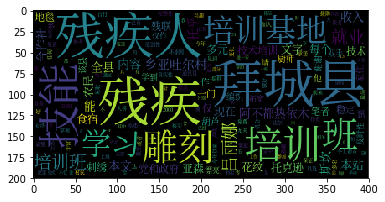

In [46]:
plt.imshow(wc.generate_from_frequencies(machine_new_keywords_dict))

# TFIDF Vectorized

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from scipy.spatial.distance import cosine

In [80]:
vectorized = TfidfVectorizer(max_features=10000)
sample_num = 50000
sub_samples = news_content[:sample_num]
X = vectorized.fit_transform(sub_samples)

def distance(v1, v2): return cosine(v1, v2)

In [71]:
rand1, rand2 = random.randint(0,10000), random.randint(0,10000)
vec1, vec2 = X[rand1].toarray()[0], X[rand2].toarray()[0]

In [87]:
rand3 = random.randint(0,80000)
rand3 = 2879
print(get_key_word_in_docment(rawdata[rand1])[:10])
print(get_key_word_in_docment(rawdata[rand2])[:10])
print(get_key_word_in_docment(rawdata[rand3])[:10])
print(distance(X[rand3].toarray()[0], X[rand1].toarray()[0]))
print(distance(X[rand3].toarray()[0], X[rand2].toarray()[0]))

[('朱婷', 28.25845378781397), ('河南队', 13.793708149015846), ('河南', 11.84786527107029), ('女排', 10.47856977990872), ('谢国臣', 9.879577462176467), ('禄丰', 8.675457479520544), ('全运会', 7.263748360484593), ('高原', 6.681417088383068), ('反应', 6.108468645011989), ('国外', 5.641812340370588)]
[('铁人三项', 9.484912442113771), ('柳州', 7.78618937220937), ('1126', 3.793660695409996), ('柳江', 3.4926306997460146), ('河面', 3.258547493712647), ('张爱林', 3.0155094450263524), ('冲向', 2.976000903742679), ('第一名', 2.63443736164161), ('世界', 2.6281280084243717), ('蒂姆', 2.3883387331153587)]
[('太监', 18.555034941697013), ('苏州', 7.05287101648208), ('织造', 7.049630766234832), ('弄', 6.719853015662965), ('局由', 4.939788731088234), ('里弄', 4.638758735424253), ('观前街', 4.462667476368572), ('图库', 3.9855462216489093), ('丝织品', 3.524815383117416), ('供奉', 3.4484270372539614)]
0.37300629876903557
1.0


In [86]:
sorted(list(range(10000)), key=lambda i: distance(X[rand1].toarray()[0], 
                                      X[i].toarray()[0]))

/Users/hang.xiang/Desktop/MyNLPCourse/venvNLP/lib/python3.7/site-packages/scipy/spatial/distance.py:702: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


[4552,
 2879,
 1678,
 3892,
 2859,
 1486,
 3319,
 1910,
 3095,
 2967,
 25,
 1467,
 1509,
 3574,
 3479,
 3480,
 4058,
 3891,
 3223,
 3965,
 3661,
 3749,
 2788,
 3101,
 3798,
 3958,
 3959,
 3960,
 4254,
 3373,
 3549,
 2985,
 4140,
 4145,
 4137,
 1621,
 54,
 2944,
 3335,
 3817,
 3192,
 3046,
 2663,
 3234,
 3129,
 4031,
 2865,
 2882,
 2863,
 2926,
 3061,
 3765,
 3830,
 3894,
 3971,
 3657,
 2899,
 2973,
 2862,
 3043,
 4075,
 123,
 3124,
 3866,
 1593,
 4059,
 0,
 1,
 2,
 27,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 26,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 108,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 109,
 11

# Build Search Engine

In [113]:
from functools import reduce
from operator import and_
import re
from IPython.display import display, Markdown

In [122]:
trans_X = X.transpose().toarray()
word2id = vectorized.vocabulary_
id2word = {i:w for w, i in word2id.items()}

def naive_search(keywords):
    return [content for content in enumerate(rawdata) if all(w in content for w in keywords)]

# def search_engine(query):
#     words = query.split()
#     query_vec = vectorized.transform([' '.join(words)]).toarray()[0]
#     candidates_ids = [word2id[w] for w in words]
#     documents_ids = [set(np.where(trans_X[_id])[0]) for _id in candidates_ids]
#     merged_documents = reduce(and_, documents_ids)
#     sort_doc_id = sorted(merged_documents, key=lambda i:disctance(query_vec, X[i].toarray()))
#     return sort_doc_id

def search_engine(query):
    """
    @query is the searched words, splited by space
    @return is the related documents which ranked by tfidf similarity
    """
    words = query.split()
    
    query_vec = vectorized.transform([' '.join(words)]).toarray()[0]

    candidates_ids = [word2id[w] for w in words]
    
    documents_ids = [
         set(np.where(trans_X[_id])[0]) for _id in candidates_ids
    ]
    
    merged_documents = reduce(and_, documents_ids)
    # we could know the documents which contain these words
    sorted_docuemtns_id = sorted(merged_documents, key=lambda i: distance(query_vec, X[i].toarray()))

    return sorted_docuemtns_id

def get_query_pat(query):
    return re.compile('({})'.format('|'.join(query.split())))

def highlight_keywords(pat, document):
    return pat.sub(repl="**\g<1>**", string=document)
    
def search_engine_with_pretty_print(query):
    candidate_ids = search_engine(query)
    for i, _id in enumerate(candidate_ids):
        title = '## Search Result {}'.format(i)
        c = content['content'][_id]
        c = highlight_keywords(get_query_pat(query), c)
        display(Markdown(title + '\n' + c))

In [123]:
search_engine_with_pretty_print('春节 假期')

In [131]:
rawdata[22987]

'新华社 照片   香港   2017 年 4 月 12 日   n   体育   2   自行车   2017 场地 世界 锦标赛 开赛   n4 月 12 日   中国队 选手 在 比赛 中   n 当日   在 香港 举行 的 2017 场地 自行车 世界 锦标赛 女子 团体 追逐赛 资格赛 中   中国队 以 4 分 32 秒 559 的 成绩 列 第九位   n 新华社 记者 卢炳辉 摄'

In [152]:
search_engine_with_pretty_print('美国')

## Search Result 0
新华社照片，石家庄，2017年4月6日\n在推进历史性工程“大考”中交出优异答卷——新华社记者就雄安新区热点问题专访河北省委书记赵克志\n河北省委书记赵克志接受新华社记者专访（4月5日摄）。\n日前，中共中央、国务院印发通知，决定设立河北雄安新区。这是以习近平同志为核心的党中央作出的一项重大历史性战略选择。雄安新区的设立对河北乃至全国改革发展意味着什么？新区如何启动实施建设？当前要把握哪些重点工作？新华社记者5日专访了河北省委书记赵克志。\n新华社记者朱旭东摄

## Search Result 1
新华社照片，东莞（广东），2017年4月5日\n（体育）（20）篮球——CBA总决赛第三场：广东东莞银行对阵新疆喀什古城\n4月5日，广东东莞银行队球员斯隆（前中）在比赛中突破。\n当日，在2016-2017赛季中国男子篮球职业联赛（CBA）总决赛第三场比赛中，广东东莞银行队主场迎战新疆喀什古城队。\n新华社记者徐子鉴摄

## Search Result 2
新华社照片，外代，2017年4月4日\n（外代二线）篮球——NBA：森林狼胜开拓者\n4月3日，森林狼队前锋威金斯传球。\n当日，在2016-2017赛季NBA常规赛中，明尼苏达森林狼队以110比109胜波特兰开拓者队。\n新华社/路透

## Search Result 3
新华社照片，外代，2017年4月4日\n（外代二线）牛车比赛\n4月1日，在缅甸内比都郊区的一个村庄，一名男子参加牛车比赛。\n新华社/美联

## Search Result 4
新书速递
　　《广陵散：中国狂士传》??日前，知名学者孟泽与徐炼所著《广陵散：中国狂士传》出版。作者穿越历史长河，对中国历代狂士进行一次酣畅淋漓的解读。超出常规、常理的言论和行动，叫做“狂言”、“狂行”，超出常规、常理的人，叫做“狂士”。这些人大都不拘礼节，任性而行。但他们却在“狂放”的外衣下，裹着一颗纯洁而热烈的赤子之心。他们不事权贵，不爱金钱，不为世俗的繁文缛节所束缚，敢于批逆鳞、捋虎须，颇有点“威武不能屈、贫贱不能移”的硬骨头精神。?
　　《故乡之食》??民以食为天，“食”在我国向来受重视。我国幅员辽阔，人口众多，物产丰富，又经过五千年的研究发展，“食在中国”已成为一个响亮的品牌。本书是一册中国版的吃货地图，全面介绍中国各地饮食菜肴以及饮食习俗，文字生动活泼，读来口舌生津。一卷在手，饱览故乡美食，重温风土人情。


## Search Result 5
新华社照片，外代，2017年4月3日\n（外代二线）婚礼时装秀\n4月2日，在巴基斯坦卡拉奇，模特展示婚礼时装。\n新华社/法新

## Search Result 6
新华社照片，外代，2017年4月3日\n（外代二线）婚礼时装秀\n4月2日，在巴基斯坦卡拉奇，模特展示婚礼时装。\n新华社/法新

## Search Result 7
新华社照片，柏林，2017年4月10日\n（一带一路·好风光）（7）德国杜伊斯堡的郢趣园\n4月7日，两名游客站在德国杜伊斯堡郢趣园内的石桥上。\n郢趣园坐落在德国西部城市杜伊斯堡的动物园内，占地约5400平方米。1985年，中国武汉市决定向友好城市杜伊斯堡赠送一座中式园林。1988年郢趣园正式建成并对外开放，成为杜伊斯堡动物园内的一处重要景观。\n新华社记者单宇琦摄

## Search Result 8
　　新华社北京4月13日电（记者于佳欣）一直以来，中美贸易顺差大饱受诟病。今年2月中国对**美国**贸易顺差同比下降28%。商务部新闻发言人孙继文13日表示，中美贸易不平衡归根结底是由两国经济结构、产业竞争力和国际产业分工决定的。\n　　孙继文在商务部当日召开的例行新闻发布会上指出，根据中方统计，2017年2月，中美贸易额330.1亿美元，同比上升7.0%。其中，中国自美进口112.9亿美元，同比上升37.9%；对美出口217.1亿美元，同比下降4.2%。中方顺差104.2亿美元，同比下降28%。\n　　**美国**商务部的数据也印证了同样的趋势：今年2月美对华贸易逆差下降了26％，美对华出口增长了22％。\n　　事实上，美中贸易逆差去年就开始缩减。据**美国**商务部数据，2016年**美国**对中国贸易逆差约为3470亿美元，较2015年下降5.5%。\n　　“中方从不追求贸易顺差。”孙继文说，贸易顺差账记在了中国头上，但利益实由双方分享。中方愿根据国内市场实际需求，扩大自美进口。希望美方也能调整出口管制等阻碍对华出口的政策，为化解贸易逆差创造条件。\n　　其实，除经济结构和产业分工等问题，贸易统计方法的不同也成为顺差与逆差之争的原因。孙继文表示，以德国为例，据中方统计，2016年中国对德出口约652亿美元，自德进口约861亿美元，德方顺差209亿美元，而德方统计则显示为逆差。（完）

## Search Result 9
新华社照片，廊坊（河北），2017年4月8日\n志愿服务星期六\n4月8日，在廊坊市华夏经典社区，志愿者与社区干部一起入户走访，了解社区居民对志愿服务需求情况。\n当日，河北省廊坊市各机关、企事业单位的90多支志愿服务队、2000多名志愿者，深入到市内90多个社区和广场开展多种形式的志愿服务活动。据介绍，今年3月以来，廊坊市以“访千楼万家创文明城市”为主题，利用每周六持续开展“星期六文明行动”志愿服务活动，内容包括公益宣传推介、普及文明礼仪、邻里互助帮扶、社区环境整治等。\n新华社记者鲁鹏摄

## Search Result 10
新华社照片，廊坊（河北），2017年4月8日\n志愿服务星期六\n4月8日，在廊坊市华夏经典社区，志愿者在为社区居民免费理发。\n当日，河北省廊坊市各机关、企事业单位的90多支志愿服务队、2000多名志愿者，深入到市内90多个社区和广场开展多种形式的志愿服务活动。据介绍，今年3月以来，廊坊市以“访千楼万家创文明城市”为主题，利用每周六持续开展“星期六文明行动”志愿服务活动，内容包括公益宣传推介、普及文明礼仪、邻里互助帮扶、社区环境整治等。\n新华社记者鲁鹏摄

## Search Result 11
新华社照片，古晋（马来西亚），2017年4月8日\n（体育）（4）羽毛球——马来西亚公开赛：戴资颖晋级决赛\n4月8日，中国台北选手戴资颖在比赛中回球。\n当日，在马来西亚羽毛球公开赛半决赛中，中国台北选手戴资颖以2比1战胜韩国选手成池铉，晋级决赛。\n新华社发（张纹综摄）

## Search Result 12
新华社照片，古晋（马来西亚），2017年4月8日\n（体育）（5）羽毛球——马来西亚公开赛：戴资颖晋级决赛\n4月8日，中国台北选手戴资颖在比赛中回球。\n当日，在马来西亚羽毛球公开赛半决赛中，中国台北选手戴资颖以2比1战胜韩国选手成池铉，晋级决赛。\n新华社发（张纹综摄）

## Search Result 13
原标题：中国航天火箭罕见发射失误，网友反应完全让人想不到
据中国航天科技集团公司官方网站消息，2017年6月19日，我国在西昌卫星发射中心用长征三号乙运载火箭发射中星9A 广播电视直播卫星，发射过程中火箭三级工作异常，卫星未能进入预定轨道，具体原因正在调查分析。目前卫星太阳帆板和天线已展开，卫星系统工况正常。各方正在采取有效措施。
中星9A卫星，是我国首颗国产广播电视直播卫星，采用中国航天科技集团公司空间技术研究院自主研发的东方红四号卫星平台，提供Ku BSS规划频段转发器直播服务。
中星9A卫星，将定点于东经101.4度，星上设计的24个Ku BSS频段转发器，覆盖全中国（含港、澳、台地区），满足我国广播电视、新媒体和直播产业发展需求。
此外，中星9A卫星专门设计了南海波束，将彻底解决南海海域、岛礁的政府、军队、人民群众收看广播电视节目的难题，确保了中国主权地区的直播卫星覆盖。
承担此次发射任务的长征三号乙运载火箭，主要用于发射地球同步转移轨道卫星，它捆绑了4个助推器，可将5.5吨以下的有效载荷送入地球同步转移轨道。自1996年首飞以来，它既承担了我国国内重要卫星发射任务，还是国际商业发射任务的主选火箭。
而在得知中星9A广播电视直播卫星因火箭三级故障未能进入预定轨道之后，网友们的反应大大出乎意料，很多网友表示，“难得看到一次发射失败，这也算是有生之年系列了。”
还有网友对于中国航天这种公开透明的态度表示肯定。认为比起无数次成功所带来的骄傲与喜悦，在失败后的的坦诚与透明才更能让人感受到真正的自信！
当然，更多的人都是在理性面对这来之不易的失败，然后纷纷给予鼓励和安慰，毕竟，想要给中国航天一次安慰也不是那么容易的。
事实上，虽然由于火箭故障导致中星9A卫星未能顺利入轨，但从技术层面而言，这并不意味着卫星就此失效。根据以往的经验，虽然卫星未能顺利入轨，但是还可以利用卫星发动机将卫星调整到预定轨道。
而根据中国航天科技集团公司官方通报，目前卫星太阳帆板和天线已展开，卫星系统工况正常。各方正在采取有效措施。
所以，这样的一场突如其来的意外，也很好的验证了广大网民对于中国航天的成熟心态。也许大家早已经习惯了你们的波澜不惊，这偶尔的一次失败就当是你们求关注吧。


## Search Result 14
新华社摄影部今日重要稿件预告\n\n今日要闻：\n\n（国际）圣彼得堡市民为地铁爆炸案遇难者哀悼祈福（已播发5张）\n\n\n\n\n新华社摄影部\n2017年4月6日11时

## Search Result 15
新华社照片，清河（河北），2017年4月13日\n河北清河：新能源汽车产销量两旺\n4月13日，河北省清河县一家新能源汽车公司的工人在为新生产的电动汽车充电。\n清河县位于河北省东南部，汽车及零部件产业是该县的支柱产业。近年来，清河县加快产业转型升级步伐，大力发展新能源汽车产业。2016年，该县生产的电动微型轿车、微型越野车、商用微型车、厢式物流车等新能源汽车销售近10万辆，产品俏销国内各地。2017年一季度，当地新能源汽车订单持续增长，产销两旺。\n新华社发（陈雷摄）

## Search Result 16
新华社照片，洛杉矶，2017年4月3日\n（体育）（1）篮球——NBA常规赛：湖人胜灰熊\n4月2日，湖人队球员托马斯·罗宾逊（右）在比赛中控球。\n当日，在2016-2017赛季NBA常规赛中，洛杉矶湖人队主场以108比103战胜孟菲斯灰熊队。\n新华社记者杨磊摄

## Search Result 17
新华社照片，常州（江苏），2017年4月23日\n（体育）（16）羽毛球——中国大师赛：田厚威男单夺冠\n4月23日，田厚威在比赛中。\n当日，在江苏常州举行的2017中国羽毛球大师赛男单决赛中，中国选手田厚威以2比1战胜队友乔斌，获得冠军。\n新华社记者季春鹏摄

## Search Result 18
新华社图表，北京，2017年4月23日\n漫画：汗水与口水\n　　《人民的名义》之所以热播，是因为该电视连续剧表达了百姓对贪腐分子的痛恨，对不作为和乱作为干部的责备，对心里装着人民和敢于反腐干部的热爱。现实中就有许多真正为人民服务的干部，他们的忠诚和胸襟与那些“口头为人民”的干部形成鲜明对比，一点不比艺术作品逊色。\n新华社发翟桂溪作\n\n\n

## Search Result 19
新华社照片，北京，2017年4月7日\n（体育）（9）足球——中超：北京中赫国安胜河南建业\n4月7日，北京中赫国安队球员姜涛（左）在比赛中防守河南建业队球员冯刚。\n当日，在2017赛季中超联赛第四轮比赛中，北京中赫国安队主场以1比0战胜河南建业队。\n新华社记者鞠焕宗摄

## Search Result 20
新华社照片，海口，2017年4月15日\n　　（体育）（2）足球——中乙：海口博盈主场获胜\n4月15日，海口博盈队球员韩超（左二）在门线处封堵对方的攻门。\n当日，在2017中国足球协会乙级联赛的比赛中，海口博盈队主场以1比0战胜梅县铁汉生态队。\n新华社记者杨冠宇摄

## Search Result 21
新华社照片，乌鲁木齐，2017年4月2日\n（体育）（40）篮球——CBA总决赛第二场：新疆胜广东\n4月2日，广东东莞银行队球员周鹏（左上）在新疆喀什古城队球员布拉切（下）和周琦的防守下突破上篮。\n当日，在2016-2017赛季中国男子篮球职业联赛（CBA）总决赛第二场比赛中，新疆喀什古城队主场以103比97战胜广东东莞银行队，从而以2比0的总比分暂时领先。\n新华社记者胡虎虎摄

## Search Result 22
新华社照片，外代，2017年4月16日\n（外代二线）足球——英超联赛：热刺胜伯恩茅斯\n4月15日，热刺队球员扬森庆祝进球。\n当日，在2016-2017赛季英格兰足球超级联赛第33轮较量中，托特纳姆热刺队主场以4比0战胜伯恩茅斯队。\n新华社/路透AI

## Search Result 23
施工公告


## Search Result 24
新华社照片，赫尔辛基，2017年4月1日\n（体育）（1）花样滑冰——世锦赛：李香凝获女单第14名\n3月31日，李香凝在女单自由滑比赛中。\n当日，在芬兰赫尔辛基举行的2017年花样滑冰世锦赛单人滑比赛中，中国选手李香凝以175.37分的总成绩获第14名。\n新华社发（马蒂凯宁摄）

## Search Result 25
　　【新华社微特稿】几乎每个人都有整夜没睡好却不得不一早起床上班的经历。怎样才能让浑浑噩噩的自己提高工作效率，少出错？\n　　英国《每日邮报》引述睡眠专家尼尔·斯坦利的话报道，首先不要赖床，到点就起来，然后打开窗户，呼吸一些新鲜空气，吃一顿丰盛的早餐，为一整天的忙碌储存能量。\n　　如果有时间，不如出去走２０分钟或者练练瑜伽、普拉提等，这样做能让你尽量保持清醒。\n　　每天早晨刚上班时通常是最有效率的时刻，因此，查看一下当天的任务清单，把最有挑战性的任务选出来第一个完成。\n　　还有一点要注意的是，喝咖啡提神可以，但千万不要喝太多。斯坦利说，一点咖啡因的确可以提神，但摄入太多会起到相反效果。（完）（荆晶）\n　　关键词：尼尔·斯坦利（NeilStanley）

## Search Result 26
新华社照片，石家庄，2017年4月12日\n四月踏青赏桃花\n4月12日，游客在廊坊市安次区唐家坟村桃园内拍摄桃花。\n近日，河北省廊坊市安次区两万亩桃林进入花期，吸引众多游客前来赏花踏春。\n新华社记者王晓摄

## Search Result 27
　　新华社北京４月２７日电综合新华社驻伊斯坦布尔、莫斯科分社记者报道：土耳其海岸警卫队和俄罗斯国防部２７日证实，俄罗斯黑海舰队一艘舰船当天在土耳其伊斯坦布尔附近黑海海域与一艘货船相撞后沉没，船上７８人全部获救。\n　　据土耳其媒体报道，俄罗斯黑海舰队“里曼”号舰船在伊斯坦布尔基利奥斯水域与一艘悬挂多哥国旗的货船相撞。事故可能因浓雾弥漫所致。“里曼”号船体受损后沉没，船上７８人全部获救。货船轻微受损。\n　　塔斯社援引俄罗斯国防部的消息报道说，俄罗斯黑海舰队一艘舰船在博斯普鲁斯海峡西北４０公里处水域与一艘货船相撞，舰船右舷吃水线以下船体被撞穿。事发后，土耳其海岸警卫队反应迅速，在舰船沉没前及时疏散了船上７８人。\n　　土耳其总理耶尔德勒姆已就此事与俄罗斯总理梅德韦杰夫通了电话。（完）

## Search Result 28
新华社长沙4月27日电（记者谭畅）27日晚，第十三届全运会篮球预赛成年男子Ⅰ组的比赛在湖南郴州进行了第五轮最后一场比赛，广东队95:47战胜陕西队，四连胜后出线在望。\n根据竞赛规程，小组前2名直接进入全运会决赛阶段，各组3、4名参加附加赛。赛前，广东队已经取得三连胜，而陕西队则是一胜三负。双方实力差距明显，首节广东队就以32:6的悬殊比分领先。最终，广东队95:47战胜陕西队。\n值得一提的是，虽然同组四连胜的上海队已提前出线，但广东队还不能确保出线，其身后的浙江队、北京队中的一支还有可能打出4胜2负的战绩。与上海队已先后战胜浙江队和北京队不同，广东队将在最后一轮对决浙江队，因此浙江队理论上还存在直接出线的可能。（完）\n

## Search Result 29
新华社照片，保定（河北），2017年4月27日\n第二届大激店世界音乐节开幕\n4月27日，一支来自阿根廷的乐队在音乐节现场演出。\n当日，第二届大激店世界音乐节在河北保定开幕。为期两天的音乐节共吸引来自意大利、阿根廷、立陶宛等多个国家的7支乐队、30多位音乐艺人参与演出。\n新华社记者朱旭东摄

## Search Result 30
新华社照片，星州（韩国），2017年4月8日\n（国际）（2）数千名韩国民众在“萨德”部署地举行抗议集会\n4月8日，在韩国庆尚北道星州郡的“萨德”部署地——星州高尔夫球场附近，民众手举标语参加抗议集会。\n来自韩国各地的数千民众当天在此举行抗议集会，要求政府停止部署“萨德”系统。\n新华社记者姚琪琳摄

## Search Result 31
\n\n

## Search Result 32
　　新华社北京4月23日电公安部23日组织天津等地公安机关打掉了一个编造“慈善富民总部”机构，以“解冻民族资产”为由实施诈骗的犯罪团伙，抓获陈玉英、陈春雨、李娜等31名犯罪嫌疑人。\n　　公安机关提醒广大群众，凡是以“解冻民族资产”为诱饵在网上宣称大额返还资金的信息，均为诈骗信息，请勿上当受骗，公安机关将依法严厉打击各类诈骗违法犯罪活动。（完）

## Search Result 33
新华社照片，钦州（广西），2017年4月21日\n广西钦州举行广场舞大赛\n4月21日，来自钦州市钦北区新棠镇的文艺队队员在表演广场舞。\n当日，广西钦州市钦北区举行广场舞大赛，29支参演队伍各展舞艺。\n新华社记者张爱林摄

## Search Result 34
新华社照片，外代，2017年4月22日\n（外代二线）乌克兰举办第15届国际美发时尚与设计节\n4月21日，在乌克兰首都基辅，发型设计师进行创作。\n当天，第15届国际美发时尚与设计节在基辅开幕。\n新华社/法新\n

## Search Result 35
　　新华社南昌４月２３日电（记者林浩）２３日，第十三届全国运动会篮球成年男子组预赛第二组的比赛在江西南昌开赛。\n　　全运会男篮成年组预赛共分湖南郴州、江西南昌、宁夏中宁三个赛区，各赛区前两名的运动队直接晋级天津全运会男篮决赛；各组第三、四名的队伍将参加附加赛，争夺决赛名额。\n　　来自辽宁、解放军、湖北、吉林、澳门、河南、重庆、西藏的代表队参加南昌赛区的比赛，比赛持续至４月２９日，赛制为单循环赛，各队每天一场比赛，排出小组名次。（完）\n

## Search Result 36
新华社照片，宾阳（广西），2017年4月23日\n一支毛笔传承的百年工匠精神\n在广西宾阳县宾州镇，65岁的大罗村毛笔老工艺人罗儒供在修笔（4月21日摄）。\n在广西宾阳县宾州镇大罗村，毛笔传统制作工艺至今已有数百年历史。一支毛笔的制作从选料到完工，要历经120多道工序，当地毛笔制作艺人将制作毛笔的技艺代代相传，锲而不舍地传承着百年工匠精神。\n新华社记者陆波岸摄

## Search Result 37
新华社照片，宜昌（湖北），2017年4月23日\n（体育）（2）极限运动——“人仰板翻”\n4月23日，中国选手周舟在比赛中摔倒。\n当日，2017卡拉宝“山丘之王”国际长板速降赛在湖北宜昌富裕山景区落幕。\n新华社记者肖艺九摄

## Search Result 38
新华社照片，北京，2017年4月27日\n（体育）（5）趣味运动欢乐多\n4月27日，北京中古友谊小学的学生和家长在进行“传送带”比赛。\n当日，北京中古友谊小学举行亲子运动会，小学生运动员在赛跑和跳远等项目后，和家长一起进行了运球接力、传送带、两人三足接力和钻圈等趣味体育项目，尽情享受春日运动带来的快乐。\n新华社记者陈晔华摄\n

## Search Result 39
中新网贵阳6月22日电 (记者 张伟)6月22日，贵州省中小企业局与贵州股权金融资产交易中心战略合作协议在贵阳签署。《协议》核心是为贵州中小企业搭建综合金融服务平台，竭力缓解中小企业融资难、融资贵难题，促进中小企业向更高层次资本市场发展。这是贵州省民营企业服务年系列活动的又一力作。
自2015年实施全省“民营企业服务年”活动以来，贵州省各地各部门扎实深入地开展“民营企业服务年”活动，推动民营经济综合实力稳步提升，2016年全省民营经济实现增加值6097.1亿元，比上年增长17.1%。
2017年，贵州将继续深入开展“民营企业服务年”活动，不断探索服务中小企业行之有效的新思路、新举措，着力破解制约民营企业发展的突出问题，优化中小企业发展环境，努力实现2017年全省民营经济增加值6800亿元的工作目标。
贵州股权金融资产交易中心是经贵州省政府批准设立，是贵州省政府打造的唯一投融资综合金融服务平台，在金融资本、产业整合、股权融资、债权融资、众筹融资等诸多金融服务方面上拥有许多优势。截至5月31日，贵州股权金融资产交易中心共推动1000家企业在中心挂牌，累计发行产品912只，主动管理累计融资额达315亿元，其中，成功帮助108家企业实现融资。


## Search Result 40
新华社上海4月11日电（记者潘清）短短一个交易日的回调整理之后，11日A股走出先抑后扬走势，沪深两市重拾升势。“雄安概念”“粤港澳大湾区概念”联袂走强。两市成交有效放大，总量突破7100亿元。\n当日上证综指以3266.22点小幅低开，总体上呈现先抑后扬走势。盘中沪指下探3244.40点后开始掉头上行，尾盘逼近年内高点后以3288.97点报收，较前一交易日涨19.57点，涨幅为0.60%。\n深证成指收报10655.79点，涨52.51点，涨幅为0.50%。\n前一交易日走势疲弱的创业板指数当日表现继续弱于两市大盘，收报1917.63点，涨幅为0.27%。中小板指数涨0.36%，收盘报6856.09点。\n股指反弹的同时，沪深两市近2000只交易品种收涨，远多于下跌数量。不计算ST个股和未股改股，两市80只个股涨停。中小板新股N实丰上市，首日涨幅为约44%。\n“雄安概念”延续强势，京津冀板块再度录得近7%的整体涨幅。与此同时，“粤港澳大湾区概念”相关个股集体走强，成为市场新的热点。\n大多数行业板块随股指收涨，建材、汽车、供水供气板块涨幅超过或接近2%。银行、煤炭、家电、石油燃气等板块逆势小幅收跌，且多为大盘股相对集中的板块，成为限制股指反弹高度的主要因素。\n沪深B指同步反弹。上证B指微涨0.01%至344.20点，深证B指张0.38%至1157.86点。\n　　沪深两市成交继续放大，分别为3266亿元和3835亿元，总量突破7100亿元。（完）

## Search Result 41
新华社照片，外代，2017年4月2日\n（外代二线）足球——英超联赛：切尔西负于水晶宫\n4月1日，水晶宫队主教练阿勒代斯现场督战。\n当日，在2016-2017赛季英格兰足球超级联赛第30轮较量中，切尔西队主场以1比2负于水晶宫队。\n新华社/路透AI\n

## Search Result 42
参考消息网6月13日报道 美媒称，最新研究显示，光可以表现为奇特的“超流体”状态，即光粒子在完全没有摩擦或黏力的情况下绕物体流过。
据**美国**趣味科学网站6月10日报道，近年的研究表明，光也可以表现得像液体那样——绕物体流过并在另一侧恢复原状。以前这种现象只在某些极端条件下——例如被冷冻至接近绝对零度的实验室装置中——被观察到。
数百年来，科学家们一直知道光可以表现出波的性状，从其源头向外发散，直至被物体吸收或反射，而物体则相应地被照亮。
本周发表在学术期刊《自然·物理学》杂志上的最新研究显示，光可以表现为更为奇特的“超流体”状态，即光粒子在完全没有摩擦或黏力的情况下绕物体流过。在这种状态下，光表现出明显的“无摩擦流动”效应，在不产生任何涟漪或漩涡的情况下绕过障碍物。有意思的是，这种效应可以在室温和环境压力的条件下观察到。
不过你需要借助某种设备。意大利莱切纳米技术研究所的科学家与加拿大蒙特利尔理工大学、伦敦帝国理工学院、意大利德尔萨伦托大学以及芬兰阿尔托大学合作，通过把薄层有机分子夹在两面反光性能超强的镜子中间，制作出一种事实上的光—物质混合流体，从而生成了这种现象。
这种超流体状态有时被称作物质的第五态，即玻色—爱因斯坦凝聚态。处于这种状态的粒子表现得如同一条宏观波，它们以相同的频率震荡，并怪异地结合了液体、固体和气体的属性。
这一研究团队的负责人丹尼尔·圣维托说：“我们研究的不同寻常之处是证明了超流体现象也可以在室温和环境条件下利用被称为偏振子的光—物质粒子来呈现。”
据该研究团队称，至于这一发现的实际效用，最明显的益处与使电力可以在接近零电阻的情况下传输的超导材料有关。通常这些材料需要利用液态氮进行极度冷冻处理。如果工程师们可以找到在室温条件下利用超流体的方法，那么这可能产生更加高效的新型光子装置，如激光器、发光二极管、太阳能电池板和光伏电池等。


## Search Result 43
资料图：中国YLC-8B反隐形雷达
　　【环球网军事6月19日报道 环球时报驻法国特约记者 姚蒙 特约记者 魏云峰 】两年一届的法国巴黎航展19日将在巴黎北部的勒布尔热开幕。《环球时报》记者注意到，相比参演机型多年不变的欧洲、笼罩在F-35隐形战机停飞阴云中的**美国**，中国这次参加巴黎航展的装备中出现多张“全新面孔”。从“鹘鹰”隐形战斗机、“翼龙-2”察打一体无人机，到各种型号的反隐形雷达，无不折射出中国对军工核心技术的掌握和应用能力。
　　民机可能“叫好不叫座”
　　据法新社报道，今年的巴黎航展拥有74万平方米的展览面积，2215家航空及与航空有关的企业参展，其中55%是外国企业，45%为法国企业。面对严峻的反恐形势，法国对巴黎航展采取了一系列强化治安措施，大批警力被部署在航展展馆及周边地区，以确保安全。
　　法国《世界报》评论称，2017年的巴黎航展可能没有大规模的购买飞机合同，今年对于飞机买卖来说不是“大年”。由于石油价格的持续走低，各航空公司便不着急更换耗油量大的老飞机，这导致新合同的减少。不过欧洲航空界认为，随着世界航空运量每年以4%-5%的速度上升，今后20年客机数量将翻倍。未来国际市场需要3.5万架新飞机，总金额达到5.3万亿欧元，因此航空业的市场前景依然被看好。
　　空客与波音两大航空巨头对航展“叫好不叫座”已经有了心理准备。空客借助“地主”优势，将在航展上推出新型A321NEO客机，此外A350-1000、A380等型号也将参展。波音公司的新机型波音737MAX和波音787也将分别在航展进行飞行表演和静态展示。中国商飞公司派出的阵容则是由支线客机ARJ-21、干线客机C919和中俄远程宽体客机组成的“三驾马车”。
　　中国派出多张“新面孔”
　　在军机领域，欧洲持续的防务开支走低，导致近年来罕有新机型亮相。参加这次航展的仍是以欧洲“台风”、法国“阵风”战斗机为代表的现役型号。多个欧洲国家都预定了**美国**的F-35隐形战机作为下一代空军主力，但最近该机被“飞行员缺氧被迫停飞”等负面新闻所笼罩，有关F-35到底会不会在航展上飞行表演的猜测备受关注。**美国**军方也故作神秘，在一开始表示不会派这种隐形战机出席巴黎航展，直到5月6日才最后宣布参展。但到底是静态展出还是升空进行飞行表演，目前人们仍不得而知。
　　相比之下，中国军团的参展装备就要“实在”得多。据《环球时报》记者了解，仅中国航空工业集团公司首次参加巴黎航展的装备就包括“鹘鹰”隐形战斗机、L-15高级教练机、“翼龙”系列无人机、直-10ME和直-19E武装直升机、运-9E军用运输机等6种型号。
　　根据中国官方的介绍，“鹘鹰”是主导未来战场的最新型多用途战斗机，具有高生存力以及优异的电子对抗性能;“翼龙”系列代表中国航空工业中高端军用无人机水平，特别是“翼龙-2”无人机今年2月底才刚首飞，这次就派出全尺寸模型参加馆外静展;直-10ME和直19-E武装直升机可以组成高低搭配，根据用户需求提供定制服务。
　　而针对航展中的各种隐形目标，中国电子科技集团公司还拿出成套的反制利器。首度参加巴黎航展的YLC-29无源雷达可以通过民用广播调频信号对隐形飞机等目标实现探测、定位、跟踪，并保证自己不被发现;此外，YLC-8B、SLC-7、SLC-12等三款雷达都针对反隐形性能进行重点优化，它们分别工作在UHF、L、S等波段，可以组网形成可靠的防空预警探测体系，保证对隐形目标的探测，并引导防空系统进行打击。
　　新概念装备有看点
　　对于困扰欧洲的“黑飞”无人机问题，中国电子科技集团公司的YLC-48“蜘蛛网”便携式多功能侦察雷达提供了解决之道。它虽然体格小，但功能却非常强大，可以全方位探测跟踪各类低空慢速小目标和迫击炮弹道目标，具有全天候、全天时工作和快速架设撤收的特点，对于保障敏感区域低空空域具有重要意义。
　　据法国《新工厂》杂志介绍，今年巴黎航展的一个新看点是飞机制造大公司与各类小型科技创新公司的结合。巴黎航展为此特别开辟了一个名为“巴黎航空实验室”的2000平方米空间，专门让创新科技公司与大公司进行交流与互动，推动两者的结合。该空间将集中展出各种新型航空科技、新动力飞机、无人机及各种空间观察手段。


## Search Result 44
（原标题：@所有人！7月1日起，这些人不能炒股了！赶快自查！）
大消息！从7月1日开始，部分“小白股民”可能失去买卖股票的资格！人人都能炒股？7月1日以后，这就不好说了。
7月1日，全民炒股时代即将终结？
据报道，中国证券业协会近期向多家券商发布《证券经营机构投资者适当性管理实施指引（征求意见稿）》，根据这份文件，投资者将被分级。部分评级偏低的投资者，在7月1日之后可能会被从股市“劝退”！
券商中国记者获悉，中国证券业协会近期向多家券商发布《证券经营机构投资者适当性管理实施指引（征求意见稿）》，投资者适当性管理又向前推进一步：对投资者进行了五类划分，对产品或服务也进行了五类划分。
一是投资者的分类：明确了投资者可按其风险承受能力由低至高至少划分为五类：即保守型、谨慎型、稳健型、积极型和激进型。
二是产品或服务的分类：包括“证券公司、证券公司子公司以及证券投资咨询机构”在内的证券经营机构向投资者销售证券期货产品或者为投资者提供相关业务服务时，应当了解产品或服务的信息，依据《产品或服务风险等级名录》制作风险等级评估文件，由低至高划分，也为五类：即低风险、中低风险、中风险、中高风险、高风险。
“A股股票、B股股票、AA级别信用债、创新层挂牌公司股票”被划入了“中风险”等级产品。按照投资者风险承受能力与产品或服务风险等级的适当性匹配标准，不适合购买“中风险”及以上风险等级产品的保守型投资者和谨慎型投资者，以后要想买股票，可能会被“拒绝”。
如何界定股票投资者风险匹配度？普通投资者划分为五类！
根据券商中国，7月1日后，中国资本市场上，只有“专业投资者和普通投资者”之分。
《办法》规定，符合下列条件之一的是专业投资者：
（一）经有关金融监管部门批准设立的金融机构，包括证券公司、期货公司、基金管理公司及其子公司、商业银行、保险公司、信托公司、财务公司等；经行业协会备案或者登记的证券公司子公司、期货公司子公司、私募基金管理人。
（二）上述机构面向投资者发行的理财产品，包括但不限于证券公司资产管理产品、基金管理公司及其子公司产品、期货公司资产管理产品、银行理财产品、保险产品、信托产品、经行业协会备案的私募基金。
（三）社会保障基金、企业年金等养老基金，慈善基金等社会公益基金，合格境外机构投资者（QFII）、人民币合格境外机构投资者（RQFII）。
（四）同时符合下列条件的法人或者其他组织：
1.最近1年末净资产不低于2000万元；
2.最近1年末金融资产不低于1000万元；
3.具有2年以上证券、基金、期货、黄金、外汇等投资经历。
（五）同时符合下列条件的自然人：
1.金融资产不低于500万元，或者最近3年个人年均收入不低于50万元；
2.具有2年以上证券、基金、期货、黄金、外汇等投资经历，或者具有2年以上金融产品设计、投资、风险管理及相关工作经历，或者属于本条第（一）项规定的专业投资者的高级管理人员、获得职业资格认证的从事金融相关业务的注册会计师和律师。
（前款所称金融资产，是指银行存款、股票、债券、基金份额、资产管理计划、银行理财产品、信托计划、保险产品、期货及其他衍生产品等）
中证协的《征求意见稿》则要求，券商将符合上述第（四）、（五）项条件的投资者划分为专业投资者，应当遵循以下程序：
（一）投资者向证券经营机构提供如下材料：
1、法人或其他组织投资者提供最近一年经审计的财务报表、金融资产证明文件、投资经历等；
2、自然人投资者提供本人金融资产证明文件或近3年收入证明，投资经历或工作证明、职业资格证书等。
（二）证券经营机构评估通过后书面告知投资者为专业投资者的结果以及证券经营机构对专业投资者和普通投资者在履行适当性义务方面的差别。
（三）投资者以书面方式承诺，已了解第（二）项规定的差别。
而专业投资者之外的投资者，即为普通投资者。普通投资者在信息告知、风险警示、适当性匹配等方面享有特别保护。
重点在于：针对普通投资者，券商则应当按其风险承受能力等级，将普通投资者由低至高划分为五类，分别为：保守型、谨慎型、稳健型、积极型和激进型。
而风险承受能力最低类别的投资者，是指风险承受能力等级经评估为保守型且符合下列情形之一的自然人：
（一）不具有完全民事行为能力；
（二）无固定收入来源，或者个人或家庭人均收入低于当地城乡居民最低生活保障标准；
（三）没有证券期货投资知识或者投资经验；
（四）没有风险容忍度或者不能承受任何损失；
（五）中国证监会、协会或证券经营机构认定的其他情形。
《指引》要求，券商应当加强投资者投资交易行为分析，利用投资者评估数据库，持续跟踪和评估投资者风险承受能力，必要时调整其风险承受能力等级。
依照“投资者风险承受能力问卷”五个答分区间，结合五类风险承受能力等级的投资者所匹配产品风险等级，7月1日之后，投资产品分布如下：
1、得分20分以下，为保守型投资者，只能购买或接受“包括但不限于国债、债券质押式逆回购业务、债券质押式报价回购业务、货币型产品、银行保本型理财产品及相关服务”（低风险）
2、得分20-36分，为谨慎型投资者，可购买“包括但不限于地方政府债、政策性银行金融债、AA+及以上级别的信用债及相关服务；国债、债券质押式逆回购业务、债券质押式报价回购业务、货币型产品、银行保本型理财产品及相关服务”（中低风险和低风险）
3、得分37-53分，为稳健型投资者，稳健型投资者可买股票，具体可购买“包括但不限于A股股票、B股股票、AA级别信用债、创新层挂牌公司股票、股票期权备兑开仓业务、股票期权保护性认沽开仓业务及相关服务；包括但不限于地方政府债、政策性银行金融债、AA+及以上级别的信用债及相关服务；包括但不限于国债、债券质押式逆回购业务、债券质押式报价回购业务、货币型产品、银行保本型理财产品及相关服务。”（中风险、中低风险和低风险）
4、得分54-82分，为积极型投资者，除以上投资产品，还可购买“包括但不限于退市整理期股票、港股通股票（包括沪港通下的港股通和深港通下的港股通）、股票质押式回购（融入方）、约定购回式证券交易（融入方）风险警示股票、AA-级别信用债、基础层挂牌公司股票、个股期权买入开仓业务、股票期权保证金卖出开仓业务、权证、融资融券业务及相关服务”（中高风险、中风险、中低风险和低风险）
5、得分83分以上，为激进型投资者，激进型投资者可购买以上所有的风险等级产品，还可以买包括但不限于复杂的结构化产品、AA-以下级别信用债、场外衍生产品及相关服务。覆盖“高风险、中高风险、中风险、中低风险和低风险”的所有投资产品或服务。
被划分为保守型和谨慎型的这两类投资者，7月1日要想炒股，会遭到拒绝。只能是先签署“产品或服务不适当警示及投资者确认书”，确认了可以交易中风险以上的品种，才能买股票。
以上意见稿是《证券期货投资者适当性管理办法》（“《办法》”）的配套规则。去年12月，中国证监会新闻发言人张晓军表示，《办法》将于今年7月1日起实施，将突出对普通投资者的特别保护，向投资者提供有针对性的产品及差别化服务。
华尔街见闻援引市场人士评价称，说它是统领市场适当性管理制度的“母法”毫不夸张。它将对传统经纪业务、资管业务、研究业务产生重大影响。各地证监局与券商已经进入备战倒计时。
去年12月张晓军介绍，《办法》主要有以下五项制度安排：
形成了依据多维度指标对投资者进行分类的体系，统一投资者分类标准和管理要求；
明确了产品分级的底线要求和职责分工，建立层层把关、严控风险的产品分级机制；
规定了经营机构在适当性管理各个环节应当履行的义务，全面从严规范相关行为；
突出对普通投资者的特别保护，向投资者提供有针对性的产品及差别化服务；
强化了监管职责和法律责任，确保适当性义务落到实处。
看看你有没有股票投资资格？个人投资者风险承受能力问卷调查表


## Search Result 45
新华社照片，外代，2017年5月1日\n（外代二线）驿马车乡村音乐节\n4月29日，在**美国**加利福尼亚州印第奥的驿马车乡村音乐节，唱作人罗伯特·埃利斯在表演。\n第一届驿马车乡村音乐节于2007年举办。\n新华社/法新\n

## Search Result 46
新华社照片，外代，2017年5月3日\n（外代二线）欧洲电视歌曲大赛即将开幕\n5月2日，在乌克兰基辅独立广场，人们在欧洲电视歌曲大赛标志的广告牌前自拍。\n2017欧洲电视歌曲大赛将于5月9日至13日在基辅国际会展中心举行。\n新华社/欧新\n

## Search Result 47
新华社照片，理县（四川），2017年4月12日\n国道317线狮子坪电站库区改线公路工程进展顺利\n这是在四川阿坝藏族羌族自治州理县境内拍摄的国道317线狮子坪电站库区改线公路工程中新建的二古溪大桥（4月12日摄）。\n目前，由中铁二局二公司承建的国道317线狮子坪电站库区改线公路工程进展顺利，预计于2017年年内竣工完成。据悉，国道317线狮子坪电站库区改线公路设计时速为40公里，全长3.023公里，桥隧占比95.3%。\n新华社记者薛玉斌摄

## Search Result 48
菲律宾军方和**美国**驻菲律宾大使馆１０日证实，美军特种部队参与了菲律宾南部城市马拉维的反恐作战。这是双方首次承认美军介入这场战事。
菲律宾军警眼下正在马尼拉以南约８００公里处的马拉维市与效忠极端组织“伊斯兰国”的反政府武装“穆特组织”和阿布沙耶夫武装等激战。反政府武装占据的地盘据信已被压缩到仅剩３个街区，至少２００名极端分子还在负隅顽抗。
菲律宾军方发言人乔－阿尔·埃雷拉１０日在马拉维召开的新闻发布会上说，美军特种部队向菲律宾军方提供了“技术支持”，但没有参加地面作战。
**美国**驻菲律宾大使馆随后表示，**美国**政府是应菲律宾方面请求施以援手的。但大使馆没有透露军事行动细节。
当地民众看到美军一架Ｐ－３“猎户座”反潜巡逻机９日掠过马拉维市区上空。
英国广播公司（ＢＢＣ）报道，美军在菲律宾的军事存在规模较小，主要负责后勤保障。美军与菲律宾军方原本有一个打击阿布沙耶夫武装的军事合作项目，但该项目于２０１５年中断。
２０１６年，菲律宾总统罗德里戈·杜特尔特上台后，多次发表反美讲话，甚至扬言要将驻菲美军赶走，菲美关系一度跌到低谷。不过，**美国**总统唐纳德·特朗普上任后，杜特尔特又主动示好。按照白宫说法，杜特尔特今年４月给特朗普打了一通“非常友好”的电话，还把以前两国关系不愉快的责任“推给”特朗普的前任奥巴马。
【不日收复】
菲律宾军方９日遭受了交火以来人员损失最惨重的一天。菲律宾军方说，１３名海军陆战队员当天在马拉维市区执行清剿行动时被火箭弹和爆炸装置炸死。迄今为止，已有５８名菲律宾军人和警察死亡，另有２０名无辜平民丧生。反政府武装方面据信损失１００多人。
埃雷拉说，有消息称创建“穆特组织”的两名头目已被打死，军方仍在核实相关情况，有“强烈迹象”表明这一消息不是空穴来风。
菲律宾军方放言要在１２日前收复马拉维。１２日是菲律宾的独立日。
菲律宾军方５月２３日根据情报在马拉维市搜捕“穆特组织”和阿布沙耶夫武装人员，引发双方交火至今。外界担心，“伊斯兰国”在菲律宾建立地区据点，从而对周边的印度尼西亚、马来西亚和新加坡构成安全威胁。


## Search Result 49
　　6月21日，国际评级机构标普发布名为《中国房地产开发商面临放缓压力，但影响可控》的报告，内容指出，中国前几大开发商比前几次下行周期期间更有条件应对接下来更加艰难的环境。
　　“中国未来地产商只有一两百家，更多的公司就是项目公司。” 上海菩悦资产创始人陈凯在6月16日易居沃顿第六期中国房地产实战研修项目课题发布会上这样说。
　　陈凯称，从房地产行业增长和行业估值来看，从2011年到2016年，房地产的整个销售面积的增速在往下掉，销售金额的增速也在往下掉。此外，房企A股的估值倍数也在往下掉。“整个行业的ROE从2010年的14%到2016年的8%，也在改变。我们回想一下，一边是大家很开心的拿地，一边是行业在集中，行业ROE在改变。”陈凯说，“房地产这个行业正在变化，这种情况下我们为什么做地产，肯定当然是挣钱了，所有的人问老百姓，你问他们这二十年你觉得什么最挣钱，毫无疑问都是买房子。”
　　标普全球评级信用分析师黄馨慧表示，“随着政府出台更多限制措施给炽热的房地产市场降温，随着融资渠道收紧，房地产行业可能会在2017年下半年和2018年经历一轮周期性下行。”
　　钜派投资集团首席执行官兼联席董事长倪建达称， “房地产行业的财务数据都很漂亮，很亮丽。万科做到了四千亿、五千亿，大家现在都进入了一万亿的行业，包括绿地和恒大都有这样的憧憬。”
　　易居沃顿研究基地指导组副组长臧建军称，“过去十几年我们进行房地产调控，核心点是把房地产作为经济发展和GDP成长的一个工具，和这次的调控有点不同，这次的调控我认为是强势政府下把房地产回归于老百姓，房子是用来住的，而且这次调控是持续的。”
　　作为央企的保利地产，被外界认为其近年来的风格较为保守，同时和万科以及中海地产之间的差距较大。
　　保利房地产股份有限公司副总经理余英表示，保利的架构进行了巨大的调整，在三千亿的基础上开辟新的产业。余英说：“军民融合和产城融合是我们发力的重点，我们看到和万科和中海的差距，主要是在城市数量上不够，位置主要是在长三角和京津冀，我们在广东省和万科没有差距，广东所有的地级市全进去了，但是在上海长三角和京津冀有差距。所以我们去年成立了一个叫淮海公司和渤海公司，还有一个浙南公司，就是要把长三角和京津冀地级市占领，要扩大我们公司的数量，每个城市来个二十个亿，加起来可能三四五战略就能够实现了。”
　　在谈到房企转型时，余英称，“我从来反对转型这一说，这么大的企业转不了，只能把传统的卖房子，从两千亿到三千亿再加上一些新业态，学习华夏幸福，有新的业态。我们做增量，我认为传统的大地产商是不可能转型的。”
　　标普在报告中称，对于一些规模较小或扩张过快的开发商来说，随着行业迎来更多调控措施，其可能发生倒闭、违约，从而加快行业整合。


## Search Result 50
新华社照片，东莞（广东），2017年4月5日\n（体育）（19）篮球——CBA总决赛第三场：广东不敌新疆\n4月5日，广东东莞银行队球员布泽尔（右）在比赛中进攻。\n当日，在2016-2017赛季中国男子篮球职业联赛（CBA）总决赛第三场比赛中，广东东莞银行队主场以91比104不敌新疆喀什古城队，从而以0比3的总比分暂时落后。\n新华社记者毕明明摄

## Search Result 51
\n新华社北京４月２０日电在一些中国观众看来，正在热播的《人民的名义》不仅是一部反腐剧，更像是一部纪录片。\n这部５５集电视剧开播不足一月，收视率却一路走高。剧中有不少权力斗争和权钱交易的内容，因此被称为“中国版《纸牌屋》”。很多人认为，这部剧彰显了中国反腐的决心。\n“《人民的名义》里面一些剧情让我觉得很亲切。”南京老城南居民杨国胜说。\n\n　　电视剧《人民的名义》剧照。图片来源于网络。\n\n剧中，假扮成警察的拆迁队想冲进工厂强拆，被工人设置的路障挡住了。\n“我们所在的地方遭遇强拆时就像剧中一样，时不时就来一帮子身上印着‘特勤’字样的人，上来就挨家挨户查户口。”杨国胜说，“后来才知道那是拆迁队的扮的。”\n２０１２年中共十八大以来，反腐力度加大。《人民的名义》契合这一大势，深刻反映了这一题材。事实上，剧中情节大多基于现实中案例。\n电视剧的一个主线是大风厂工人被卖掉股权。６１岁的编剧周梅森本人就经历过类似遭遇。\n２０１４年，周梅森持有的一家银行的股权被一民营企业违规抵押，后来民企资金链断裂，他卷入股权官司，损失了此前几十年赚的上千万元。\n“亲身经历让我深刻地了解了中国地方经济乱象，对人性有了更深刻的认识。”他说，“这场股权官司走进了《人民的名义》。中央的反腐成效越来越大，让我有了信心。”\n剧中刻画了一个信访局，“脸难看，事难办”，甚至特地把信访窗口建得“高不成低不就”，让信访民众站也不是蹲也不是，借此减少访民停留时间。\n\n\n这样的信访窗口曾真实存在于江苏省徐州市某区，为周梅森亲眼所见。“我当时挂职，管不了，只能作为作家凭良心把对这个的感受写出来。”\n在经历过反腐震荡的山西，民众对腐败有着咬牙切齿的痛恨。剧中出现的“煤炭资源整合”、“塌方式腐败”等字眼，让山西一名受访干部“看得刺心”。\n剧中，公安厅长为巴结上级领导“哭坟”，还到退休官员住所殷勤地锄草。剧中一些腐败案例被认为在山西也曾经真实存在。\n“这是个相互作用的过程，下级干部对上级干部有影响，上级干部对下级干部也有影响；社会的整体风气对具体干部有影响，腐败干部的行为对社会整体的风气也有影响。”山西那位干部说。\n中国煤炭大省山西曾是腐败重灾区。仅２０１４年全省各级纪检监察机关就处分了违纪党员干部１５４５０人。２０１３年以来落马的省部级干部有７人。\n山西的腐败情况也出现在去年热播的纪录片《永远在路上》。这部由中纪委和中央电视台联合制作的八集纪录片，曝光了几十名官员的贪腐细节和思想转变。\n\n　　《永远在路上》电视剧画面。图片来源于网络。\n\n据最高人民法院院长周强今年两会期间做的工作报告，去年各级法院审结贪污贿赂等案件４.５万件６.３万人，其中，被告人原为省部级以上干部３５人，厅局级干部２４０人。\n“十八大之后，反腐某种程度上改变了基层拆迁乱象纷争的局面。”杨国胜说。\n《人民的名义》受到热捧，在电视上收视率最高超过５，甚至高于当年热播剧《武媚娘传奇》大结局的收视率。观众来自多个年龄段，在网络上《人民的名义》和“雄安新区”同为最受关注的话题。\n演员吴刚在剧中饰演了一位耿直的市委书记。他坦言最初没想到有这么多观众关注这个剧。除了跌宕的剧情、精彩的表演，更重要的原因是这个剧“让人们看到人性的温暖、正义的力量。”他说。\n“追剧只是表象，从人民内心来说还是向往一种风清气正的社会现实。”山西省社科院一名不愿透露姓名的学者说，“追剧的现象更加说明，反腐并未远去，反腐一直在路上。”\n“希望社会能见度进一步透明，反腐高压势头延续下去，让世道人心有一个明显的好转。”周梅森说。（新华社记者：白旭、房宁、蒋芳、明星、刘翔霄）\n

## Search Result 52
新华社照片，路透，2017年4月10日\n（体育）（7）足球——英超：埃弗顿胜莱斯特城\n4月9日，莱斯特城队主教练莎士比亚在场边。\n当日，在2016-2017赛季英格兰足球超级联赛第32轮比赛中，埃弗顿队主场以4比2战胜莱斯特城队。\n新华社/路透\n\n\n

## Search Result 53
　　提示声明：
　　本文所涉及的市场策略分析不代表中证网观点，不作为投资者买卖股票的依据，股市有风险，投资须谨慎。
　　编者按：本周一，沪深两市接近平盘开市，早盘两市快速冲高，随后市场全天维持高位盘整。今日市场仍旧维持地量水平，不过盘面上个股涨多跌少，权重板块企稳反弹，市场热点再度轮转。
　　明日A股将如何演绎？投资者应如何操作？且看众名家与机构的最新研判。?
巨丰投顾：量能不足掣肘反弹行情
　　【盘面简述】
　　早盘两市低开高走，上证50指数强反弹；午后股指高位震荡。盘面上，航天军工、券商信托、保险、煤炭、钢铁、新三板、家电、丝绸之路、粤港自贸、北斗导航、深港通等板块涨幅居前；黄金概念、有色、环保、雄安新区、银行等小幅回调。
　　【巨丰观点】
　　早盘两市低开高走，上证50指数强反弹；午后股指高位震荡。盘面上，航天军工、券商信托、保险、煤炭、钢铁、新三板、家电、丝绸之路、粤港自贸、北斗导航、深港通等板块涨幅居前；黄金概念、有色、环保、雄安新区、银行等小幅回调。
　　航天军工板块延续周五强势，午后扩大涨势：中航电子大涨，中航黑豹、航天电子、浩丰科技、光电股份、光电控制、中直股份、中航飞机、航发控制等涨幅居前；机构普遍看好军工股机会，后市可以低吸。
　　保险板块延续周五的反弹走势：中国平安、中国太保、新华保险领涨。券商板块表现出色：中原证券、国金证券、国元证券、海通证券、国泰君安、方正证券、中国银河、西部证券等涨幅居前。消息面上，证监会主席刘士余在证券业协会第六次会员大会上明确证券业发展的四个指挥棒，再提“创新发展”。
　　丝绸之路概念午后震荡走高：西部建设涨停，北新路桥、建设机械、天山股份、连云港、新疆城建等涨幅居前。八一钢铁冲板，带动钢铁板块走高：方大特钢、南钢股份、韶钢松山、新钢股份、马钢股份涨幅居前。
　　巨丰投顾认为自5月以来，大盘已经走出了3重底的走势，并开启中级反弹行情。沪指在上证50及白马股推动下率先反弹，但遭遇60日、120日均线强压力而出现调整。周一，上证50权重股卷土重来，券商、保险、军工等拉升明显；但市场量能始终无法释放出来，场外资金观望情绪浓厚。市场反弹的高度，主要取决于市场量能水平。建议投资者重点关注半年报大幅预增的错杀股。


## Search Result 54
新华社照片，科伦坡，2017年4月17日\n（国际）（4）斯里兰卡垃圾山坍塌死亡人数增至30人\n4月17日，斯里兰卡救援人员在首都科伦坡近郊的垃圾山坍塌现场展开搜救行动。\n斯里兰卡军方17日表示，随着搜救工作继续，首都科伦坡近郊垃圾山坍塌遇难人数已升至30人，其中包括6名儿童。\n新华社发\n\n

## Search Result 55
　　北京时间6月21日，足协杯第四轮全面开打。江苏苏宁易购队坐镇主场对阵河南建业队，两队将在南京奥体中心体育场展开一场较量，争夺足协杯8强的席位。今天下午，苏宁赛前发布会在奥体中心进行，苏宁主教练卡佩罗携阵中后防大将李昂出席。
　　在介绍球队赛前训练情况时，卡佩罗表示：“我们在周日的比赛后进行了针对性的训练，训练的效果非常理想。我很满意队伍训练的表现，我觉得我们现在有一个新的开始，会踢得越来越好的。”
　　跟随主帅一起出席赛前发布会的李昂在谈到明晚一战时表示：“这两天教练对于我们的训练要求哦的非常严格，在细节方面也做得非常好，做了很多针对性的部署，相信明天会是一场精彩的比赛，我们在我们的主场一定要拿下对手。”
　　足协杯对于江苏足球来说是一个传统优势赛事，考虑到目前双线作战的情况，主帅在两项赛事中有没有一个战略性的策略？转会窗口已经开启您有没有相应的规划？面对这些问题，卡佩罗说：“我还没有你说的这样需要做选择，我们无论在联赛还是足协杯中都要取得好成绩，我相信我们的队伍有这样的实力。另外，我的注意力只会集中在赛场上不会集中在转会市场上，我只需要我的队员到场上之后把他们所有能做出来的做出来就可以了。”
　　这场比赛为什么会带李昂参加发布会？对此，卡佩罗坦言：“他是大家心中选出的，这次我们带李昂是因为他是明天首发球员，下次我也会更换别的球员，大家拭目以待吧。”（曲小尤 发自南京）


## Search Result 56
新华社照片，外代，2017年4月10日\n（外代二线）足球——英超联赛：埃弗顿胜莱斯特城\n4月9日，埃弗顿队球员盖伊（右）与莱斯特城队球员格雷争抢。\n当日，在2016-2017赛季英格兰足球超级联赛第32轮较量中，埃弗顿队主场以4比2胜莱斯特城队。\n新华社/路透AI

## Search Result 57
新华社照片，外代，2017年4月26日\n（外代二线）足球——德国杯：法兰克福晋级决赛\n4月25日，门兴格拉德巴赫队球员索乌在最后点球大战中主罚的点球被法兰克福队门将赫拉德茨基扑住。\n当日，在德国门兴格拉德巴赫进行的2016-2017赛季德国杯半决赛较量中，法兰克福队与门兴格拉德巴赫队在常规时间内战成1比1平。最后法兰克福队在点球大战中以7比6胜出，挺进决赛。\n新华社/路透AI

## Search Result 58
新华社照片，慕尼黑（德国），2017年4月9日\n（体育）（4）足球——德甲：拜仁胜多特蒙德\n4月8日，拜仁慕尼黑队球员里贝里（左）与多特蒙德队球员罗德在比赛中争抢。\n当日，在2016-2017赛季德国足球甲级联赛第28轮比赛中，拜仁慕尼黑队主场以4比1击败多特蒙德队。\n新华社发（菲利普·鲁伊兹摄）

## Search Result 59
新华社北京4月28日电（记者孙辰茜）外交部发言人耿爽28日奉劝所谓**美国**国际宗教自由委员会停止借宗教问题干涉中国内政。\n　　当日例行记者会上，记者问：近日，**美国**国际宗教自由委员会发布2017年度报告，继续建议将中国列为“特别关注国”。你对此有何评论？\n　　耿爽说，中国政府依法保护公民的宗教信仰自由。中国各民族、各地区人民依法享有充分宗教信仰自由。这一事实有目共睹，不容置疑。\n他说，这个所谓委员会对华一贯充满政治偏见，无视中国在宗教领域取得的进展，年复一年发表报告诋毁中国的宗教政策和状况，其谬论不值一驳。“我们奉劝他们尊重客观事实，摒弃偏见，停止发表有关报告，停止借宗教问题干涉中国内政。”（完）

## Search Result 60
　　新华社北京４月３０日电（白瀛、杨春）数据显示，２０１３年至２０１６年，全国广电公益广告制作量和播出时长均増长了４倍。专家呼吁，充分利用新媒体传播平台，进一步加强公益广告传播效果。\n　　２０１０年元旦起施行的《广播电视广告播出管理办法》规定，播出机构每套节目每日公益广告播出时长不得少于商业广告时长的３％，其中广播电台在１１时至１３时之间、电视台在１９时至２１时之间，公益广告播出数量不得少于４条（次）。从此，广播电视公益广告在我国迅速发展。\n　　日前在京召开的２０１７年全国广电公益广告论坛上，新闻出版广电总局传媒机构管理司司长袁同楠介绍，２０１３年，全国各级电台电视台公益广告的制作量为３万余条，播出时长为６００余万分钟；到２０１６年，这两个数字分别为１５万条、３０００余万分钟，增长均约为４倍。\n　　“总的来看，我国广播电视公益广告的创作已经进入一个提质增效繁荣发展的新阶段。”袁同楠说。\n　　袁同楠同时指出，公益广告要创新传播方式，适应当前新媒体、特别是移动新媒体短视频传播的重要趋势，大力推动广播电视广告的融合传播、互动传播、共享传播。\n　　新闻出版广电总局网络视听节目管理司司长罗建辉建议，主流媒体要借助目前新媒体出现的新形态，调动相关力量和各方面积极性，强化公益广告传播效果。\n　　“让公益广告不仅呈现到墙上、纸上、电视荧屏上，更要见诸互联网、手机和新媒体客户端。”中国新闻出版传媒集团董事长马国仓说。（完）

## Search Result 61
新华社照片，外代，2017年4月13日\n（外代二线）纽约国际车展媒体开放日\n这是4月12日在**美国**纽约国际车展上拍摄的本田Clarity混合动力汽车。\n当日，2017纽约国际车展举行媒体开放日活动。本次车展将于4月14日至23日向公众开放。\n新华社/美联

## Search Result 62
新华社照片，外代，2017年4月2日\n（外代二线）波音787-10梦想客机首飞成功\n3月31日，宾客参加波音787-10梦想客机首飞仪式。\n当日，**美国**波音公司最新型客机波音787-10梦想客机在南卡罗来纳州查尔斯顿国际机场首飞成功。\n新华社/路透\n\n

## Search Result 63
新华社照片，外代，2017年4月16日\n（外代二线）非洲狮幼崽\n4月12日，在俄罗斯叶卡捷琳堡动物园，两只新出生的非洲狮幼崽与妈妈在一起。\n新华社/卫星社

## Search Result 64
新华社照片，外代，2017年5月3日\n（外代二线）毕业时刻\n5月1日，在也门萨那，也门大学生参加毕业典礼。\n据媒体报道，持续的动荡局势导致也门失业率升高。\n新华社/欧新\n

## Search Result 65
（原标题：专访“一国两制”研究中心总裁张志刚：“一国两制”超额完成）
中新社香港6月19日电 题：专访香港“一国两制”研究中心总裁张志刚：“一国两制”超额完成
如果以100分为满分，香港特区政府行政会议成员、“一国两制”研究中心总裁张志刚信心满满地表示，他会给“一国两制”20年来的实践打200分。
香港回归20周年之际，张志刚在接受中新社记者专访时说，“一国两制”在香港实践20年，可以说是超额完成。
“‘一国两制’的初衷，就是希望社会制度不变，原有生活方式不变，这是完全百分之百完成的。但现在除了保持不变之外，你能看到‘一国两制’给香港社会的发展及生命力加了分数，这在之前是完全没有想过的。”张志刚对记者说。
1997年至2003年，刚刚回归祖国的香港先后经历亚洲金融危机和“非典”疫情的冲击，是香港回归后最困难的时期。为提振香港经济，中央政府先后推出内地居民赴香港“自由行”政策、《内地与香港关于建立更紧密经贸关系的安排》(CEPA)等惠港措施。
“就是因为有‘一国两制’，香港才可享受这么多特惠，这在之前是完全没有想过的。最初，香港人只想着不要改变，顺利过渡，维持现有生活方式不变，强调的是不变。所以，‘一国两制’是超额完成的。”
“一国两制”研究中心是专门研究香港公共政策的民间机构，在1990年底由一群关心社会的香港知名人士创办。回归前，中心长期就过渡期及落实《基本法》的一系列问题进行研究探讨；香港特别行政区成立后，中心的研究重点转移至香港内部运作所面对的经济社会重大问题，以及与内地和邻近地区的经济合作上，继续其作为特区政府以外公共政策智囊的角色。
张志刚表示，“一国两制”和《基本法》是创新的实践，没有先例可循，因此在回归前确实引起一些担忧，但回归后的实践，已证明其是成功的。
“过去20年，香港的税收越来越多，金融机构越来越蓬勃，股票市场、银行制度也比过去要好，仍然是司法独立，继续保持全球最自由经济体……”张志刚指出，不同机构的研究都显示，超过八成、绝大多数的香港人都支持“一国两制”，认为“一国两制”是对香港最好的安排。
但他同时指出，香港仍然有少数人曲解《基本法》的部分条文，甚至有意无意地作出另一种演绎。这对《基本法》的实施有一定的障碍，必须加以克服和纠正。
回顾过去20年的发展，张志刚认为，香港各方面均比1997年回归前好。“如果和以前比较，你可以看到所有的实际数据，都是比以前好。无论是对民生的关顾、对基层市民的照顾、对弱势社群的照顾，包括对少数族裔的照顾，以政策比政策，以实效比实效，现在的情况是比过去都要好的。”
张志刚又以自己切身的体会告诉记者：“以前每当长假期，直通车车票都要通宵排队，现在海关的关口越来越多，设备也越来越先进，十多分钟就能过关，这在以前是不能想象的。”展望未来，香港和内地的融合是大趋势，随着高铁香港段即将落成，以及粤港澳大湾区城市群的发展机遇，香港将迎来另一个飞跃。
“香港的发展与内地是分不开的。回归前，香港的角色是转口港，做贸易，到后来中国改革开放，我们的工厂移到内地，经济转型。回归后，我们变成旅游中心，国企来港上市……”张志刚说，20年来，香港的优势一直保持，随着国家发展，香港的优势将更突显。


## Search Result 66
新华社照片，外代，2017年4月12日\n（外代二线）越南巴沙鱼捕捞加工\n4月11日，越南巴沙鱼加工厂的工人们在加工鱼片。\n新华社/西霸

## Search Result 67
（原标题：云南一14岁女孩打赏主播 母亲银行卡被掏空）
云南网讯 短短半个月，银行流水账单里的10多项转款记录，让谭女士彻底蒙了。近7000元钱，在她毫不知情的情况下被依次转到了一个陌生账户里，难道是银行卡被人盗刷？直到前两天看到在北京读书的大女儿发来的截图，她才明白，原来这些钱被14岁的小女儿看网络直播时“打赏”给主播了。
谁干的
卡里6800元不见了全被女儿打赏主播
看着手里的银行流水单，谭女士气不打一处来。10多年前，为供两个女儿读书，她和丈夫来昆明打工，在各大工地四处找活干。前两天，为跑活方便，夫妻二人贷款买了辆车，6月8日还车贷的日子，但谭女士却收到银行短信称余额不足。
“每月要还2700元车贷，所以3月在卡上存了1万多元自动扣款，但3个月就说钱没了。”谭女士以为是提前扣款，又向卡里转了3000多元，可没过几天又提示余额不足。谭女士赶紧向在北京读书的大女儿求助，两人交流觉得可能跟小女儿有关。
“那两天我晚上一回家，她就缠着我要手机。我看她就是戴个耳机跟着视频里唱歌，也没注意，没想到她是在看直播，卡里的钱都用来 打赏 主播了。”谭女士赶到银行查流水，果不其然，半个多月时间，她卡中的钱被一笔笔转进了一个陌生账户，最多一次转了1200元，前前后后花了6800元。
“直播平台上，1元可充10个金币，然后用金币可以买鲜花、飞吻送主播，我们后来查了记录，女儿送出去的礼物记录就有10多页。”谭女士介绍，女儿之所以知道银行卡密码，是网购时自己输密码被小女儿看到，谁料她就记下了。
谁负责
父母未尽到责任平台也应严把关
未成年人花费巨款打赏主播，近年来已经有不少这类事情见诸报端。前不久，上海13岁女孩看直播打赏主播18万的新闻就引起了人们的热议。那么，未成年人因此支出的金钱能否追回呢？云南萃峰律师事务所主任李世华认为得分情况而议。
“孩子要给主播打赏但钱从哪里来？多是从父母那里偷偷拿出来的。父母并没有尽到监管、教育的责任。”李世华说，就直播平台而言，在开通打赏功能时，应尽力完善相关打赏行为人的相关审核和监管的机制。
“未成年人属于限制行为能力人，当打赏金额与其行为能力不匹配或盗用监护人财产进行打赏，而且直播平台也未对此作出提示或身份验证时，应当认定为存在过错，监护人可向受益方要求返还。”不过，李世华认为，现在很多直播平台的“打赏”功能虽然在充值时显示了“跳窗提醒”或“服务协议”，但依然缺少需实名认证与身份审核等环节，因此，平台方应该严格把关打赏机制，推动网络实名制的进程。
咋教育
父母应有的陪伴别让网络来代替
事情发生后，谭女士不再给女儿玩手机，且后悔没把女儿管教好。
云南新新华医院精神科主任医师任忠文认为，一味地禁止孩子玩手机或以打骂的方式来管教孩子，只能起到短暂的约束作用，最关键的还是得让父母花时间去陪伴孩子。
任忠文说，像谭女士的孩子，正因父母对子女关心和教育的缺失，孩子自己在家无聊，便上网看直播，通过打赏礼物可能还能得到主播的嘘寒问暖，所以才做出疯狂打赏行为。“父母在家庭教育中，不应只会说教和批评，需要付出更多的时间和关心，引导孩子如何正确地对待网络世界。”


## Search Result 68
新华社上海3月31日电（记者郑钧天）上海市住房公积金管理委员会31日发布数据显示，虽然2016年上海市公积金缴存总额明显增长，但用于发放房贷笔数和金额双双下降。\n2016年，上海市公积金发放个人住房贷款18.3万笔，金额1184.59亿元，同比分别降低8.29%、0.69%。截至2016年底，累计发放个人住房贷款233.81万笔、金额6472.82亿元，同比分别增长8.5%、22.4%。\n上海公积金的缴存总额明显增加。截至2016年底，缴存总额7115.14亿元，同比增长16.71%。2016年，实缴单位31.39万家，实缴职工764.74万人，当年缴存额1018.58亿元，同比增长15.62%。\n值得关注的是，贷款职工中，中低收入群体占据绝大多数。其中，低收入群体占35.36%，中等收入群体占62.1%，高收入群体占2.54%。（完）

## Search Result 69
点击图片进入下一页
点击图片进入下一页
点击图片进入下一页
点击图片进入下一页
点击图片进入下一页
点击图片进入下一页
中国城市综合经济竞争力报告显示
中西部城市后发 优势将逐渐凸显
首先，从综合经济竞争力来看，有以下四大发现。其一，与2015年相比，武汉首次跻身第10位，无锡跌出前10行列，台北超越广州跻身第4位。十强城市主要集中在珠三角、长三角、环渤海和港澳台地区，中部地区开始有城市进入综合经济竞争力十强，西部地区尚无城市进入十强。其二，从综合经济竞争力指数分布来看，东南地区和环渤海地区的城市均值高于全国平均水平。其三，中国城市的综合经济竞争力进入调整期，总体水平出现微幅下降。其四，从中国城市综合经济竞争力的空间分布来看，东经110度经线以东和以西地区差异明显：那些具有强竞争力优势的城市皆位于该经线以东的东中部地区。


## Search Result 70
新华社照片，东莞（广东），2017年4月5日\n（体育）（17）篮球——CBA总决赛第三场：广东不敌新疆\n4月5日，新疆喀什古城队主教练李秋平（中）在场边指挥。\n当日，在2016-2017赛季中国男子篮球职业联赛（CBA）总决赛第三场比赛中，广东东莞银行队主场以91比104不敌新疆喀什古城队，从而以0比3的总比分暂时落后。\n新华社记者毕明明摄

## Search Result 71
新华社照片，路透，2017年4月17日\n　　（体育）（1）足球——英超：曼联胜切尔西\n4月16日，曼联队球员拉什福德庆祝进球。\n当日，在2016-2017赛季英格兰足球超级联赛第33轮比赛中，曼彻斯特联队主场以2比0战胜切尔西队。\n新华社/路透\n\n

## Search Result 72
参考消息网6月22日报道 西媒称，一名摩托车手骑着心爱的铃木摩托车，载着妻子出发去旅行。在短暂休整用餐之后，他开着爱车再次上路，但开出40公里才发现，原来妻子并没有坐在身后。这个故事似乎是电影中的桥段，但却发生在59岁的意大利人瓦尔特·加洛和妻子拉法埃拉身上。
据西班牙《阿贝赛报》6月20日报道，夫妻两人都是摩托车爱好者，并且喜欢骑车外出旅游，欣赏沿路风景。近日两人骑车在意大利阿斯蒂省游玩，途中决定在小镇蒙卡尔沃停下来休息一下并大吃一顿。吃饱喝足之后，瓦尔特最后看了一眼当地的美景便戴上头盔骑着摩托车飞驰而去。他在驾驶过程中十分专注，甚至没有确认妻子是否坐在身后。到达都灵省之后，他猛然发现妻子不见了。
起初瓦尔特以为妻子不幸坠车，情急之下拨打了急救电话。一支巡逻队伍迅速抵达现场，只见瓦尔特已经泣不成声。他告诉巡警自己不可思议的经历，并恳请他们帮助找到妻子。而且他也无法打电话联系妻子，因为她的手机在摩托车上的行李箱中。巡警当即决定沿着瓦尔特走过的道路搜寻他妻子的下落。
然而，此时愤怒的拉法埃拉正身处小镇。在向当地居民借到手机之后，她怒不可遏地给瓦尔特打电话说：“你把我落在蒙卡尔沃了！快点回来接我！”拉法埃拉很快挂了电话，甚至没有给瓦尔特留时间询问她的现状。接到妻子电话后，瓦尔特迅速骑上摩托车，争分夺秒地回去接妻子。当他回到蒙卡尔沃找到拉法埃拉时，她的气依然没有消，大声质问为什么会把自己丢下。瓦尔特事后回忆说，当时夫妻二人走向摩托车，自己戴上头盔后感觉到妻子把行李放到了车上，满心以为她也坐上了车，于是便从从容容地骑车上路了。
瓦尔特指天发誓自己没有健忘症，这只是一时疏忽。他说自己的失误就像某些父母把孩子落在汽车当中一样。但是拉法埃拉似乎并不愿接受他的解释，并表示再也不会乘坐他的摩托车。当然这只是气话，和很多喜剧电影一样，瓦尔特和拉法埃拉的故事一定也会有一个幸福的结局。（编译/刘丽菲）


## Search Result 73
中新网6月16日电 6月15日，由上海市商务委、上海市长宁区政府指导，长宁区青联与亿欧联合主办的“2017中国互联网+新商业峰会”在上海举行。齐家网作为垂直行业龙头企业应邀出席，齐家网创始人邓华金则在峰会主会场发表主题演讲，阐述消费升级背景下互联网家装的趋势变化和破局之道。
点击图片进入下一页
我国经济进入新常态以来，消费对经济增长起到的基础性作用持续增强。消费对经济增长的贡献率稳步提升，从2005年的38.7%增长到2017年一季度的77.2%，成为我国经济增长的重要支撑，居民消费结构也在加快升级。
可以说，消费升级已经成为既成事实，对推动经济结构调整和提升人们的物质生活水平都有重大意义，在这股大潮下，正在崛起的中产群体逐渐成为消费的中心一极，谁能用高品质的产品抓住他们的注意力、他们的感官感受，谁能用高品质的服务和体验抓住他们的情感和认同，谁就有可能抢占消费升级的高地，把未来提前握在手里。
而早在这股浪潮兴盛之前，齐家网就已经在品质和服务的打磨上进行了前瞻性布局，构建了先发优势和竞争壁垒，为用户口碑的沉淀打下坚实基础。
在品质维度，齐家网是业内最早重视和持续发力的企业之一。从早年的高品质建材零售，到优质装修公司的推荐平台，再到如今对施工质量、品质交付的把控和追求，齐家网创立12年来，力求将品质做到极致，帮助用户实现轻松、放心的家装体验，实现“家之所在，心之所安”的品质生活。而近年来，齐家网基于建材家居领域建立的口碑旺铺体系也已成为业内典范，集聚了一批建材家居领域最具口碑、最好品质的品牌和产品，深受用户欢迎。


## Search Result 74
\n新华社武汉4月11日新媒体专电（记者廖君）武汉市民出行长沙、合肥、南昌，可以刷武汉的城市“一卡通”；建立四市诚信企业、诚信个人和失信黑名单互认制度；联合开展招商引资，建立招商引资信息共享机制……在10日举行的长江中游城市群省会城市第五届会商会上，长沙、合肥、南昌、武汉端出了交通、旅游、教育、医疗等多盘“合作大餐”。\n2016年，四市交通部门在合肥举行四城市交通运输联席会，签署了《长江中游城市群互联互通战略框架协议》和《长江中游城市群省会城市交通一卡通合作框架协议》，进一步细化了交通一卡通工作方案及工作步骤。目前，有关部门正积极筹备设立华中一卡通公司，四市通用的公交“一卡通”即将投入试运行。\n四市已开发“长江中游城市群旅游年卡”，四市市民只要花200元，就可以不限次数游览4市43个旅游景点。下一步，还将推行“旅游一卡通”并逐步扩大景点数量。\n与此同时，四市将建立地区间诚信企业、诚信个人和失信黑名单互认制度，营造“一处守信、处处受益，一处失信、处处受制”的社会诚信发展环境：加强劳动保障监察，联合开展年终务工人员工资清欠行动。\n四市还将利用中博会、名优创新产品展销会等活动平台，联合开展经贸洽谈和招商引资活动，探索医生跨四城多点执业试点。\n

## Search Result 75
新华社照片，路透，2017年4月3日\n（体育）（5）网球——迈阿密公开赛：费德勒男单夺冠\n4月2日，西班牙选手纳达尔在比赛中回球。\n当日，在2017迈阿密网球公开赛男单决赛中，瑞士选手费德勒以2比0战胜西班牙选手纳达尔，夺得冠军。\n新华社/路透

## Search Result 76
新华社照片，雅典，2017年4月20日\n（国际）（1）希腊总统说“一带一路”高峰论坛具有全球性意义\n4月20日，希腊总统帕夫洛普洛斯（右）在雅典会见新华社社长蔡名照。\n希腊总统帕夫洛普洛斯20日在雅典会见新华社社长蔡名照时说，即将在北京召开的“一带一路”国际合作高峰论坛具有全球性意义，证明在新的历史时期，中国将在推进世界和谐共存方面发挥重要作用。\n新华社记者叶平凡摄

## Search Result 77
参考消息网6月20日报道 西媒称，近来，在地铁中的不同坐姿成为人们热议的话题，尤其是所谓的“大爷式占座”在好多城市引发了人们的抵制，认为这种将双腿张开的坐姿是一种不雅且没有教养的行为。不过，最近有一张照片中女乘客的坐姿在全球社交网站热传的原因却与教养无关。
据西班牙《先锋报》网站6月18日报道，这位正坐在纽约地铁列车上的女性的腿呈“双交叉”姿态。这个怪异的姿势让很多网友都不由自主地模仿起来，以测试自己双腿的柔韧性。
普遍的观点认为，在翘二郎腿时，处于下方的那条腿的膝盖会对腓总神经造成压力。有研究指出，长时间两腿交叉坐在地上甚至可能导致腓总神经麻痹。
报道称，包括加拿大卡尔加里大学和荷兰奈梅亨大学在内的不少机构在研究中发现，当人跷二郎腿坐着时，血压会升高。
不过，土耳其的一项研究表明，只要改变姿势，几分钟后血压就会降至正常水平。此外，一条腿搁在另一条腿上能够增加心脏的血液泵量。研究还表明，二郎腿的姿势对那些容易晕倒的人来说有有利的一方面，因为这种姿势还能提高脑供血。
但这也意味着罹患血栓和心血管疾病风险较高的人群不应长时间跷二郎腿，因为这容易导致深静脉血栓的形成。
还有研究指出，习惯每天长时间跷二郎腿坐着的人更易驼背。不过韩国仁济大学的研究打消了人们的疑虑。研究称，只要挺直后背坐着，跷二郎腿不会影响身姿。
另一方面，鹿特丹大学医学中心的专家研究发现，跷二郎腿可能会为人们的肌肉带来好处。研究结果表明，在膝盖处交叉双腿能够拉伸梨状肌，提高骨盆关节的稳定性。（编译/韩超）


## Search Result 78
\n新华社北京4月11日新媒体专电(记者史竞男)4月11日,《新华每日电讯》刊载题为《反腐剧归来激扬了荧屏正气》的评论。反腐剧沉寂多年,一朝归来。\n在玄幻、仙侠、戏说、穿越等“架空历史”类电视剧充斥荧屏的当下,《人民的名义》“横空出世”,引发广泛关注和热烈讨论,成为一部“现象级”作品。它的出现,不仅为主旋律现实主义电视剧扛起了大旗,也为当前电视剧创作领域吹进了新风,激扬了正气。\n近几年来,随着IP剧统领市场,主旋律剧不断弱化、边缘化,反腐剧等“政治剧”更是在荧屏上难觅踪迹。其实早在十几年前,反腐剧也曾红极一时,如《苍天在上》《人间正道》《大雪无痕》《省委书记》《绝对权力》《国家公诉》等电视剧,都曾引发收视热潮,但也出现了同类型题材蜂拥而上、“过多过滥”的问题。2004年4月,有关部门一纸禁令,涉案剧被撤下“黄金档”,从此淡出观众视线。\n党的十八大以来,反腐败力度之大、行动之坚决前所未有,打虎、拍蝇、猎狐等行动深入人心,反腐剧也迎来了新生的契机。此前,《人民的名义》总制片人、导演李路在接受我采访时表示:“面对这场声势浩大的反腐败斗争,如果没有文艺作品进行反映和表达,这不得不说是一种缺位。当代电视剧作应该也必须有所反映,这是电视剧作为大众文艺需要承担的社会责任。”\n暌别荧屏已久的反腐剧今朝归来,可以看作是“应运而生”,正当其时；从另一种意义上来讲,也是对当前电视剧创作领域的一场“拨乱反正”。\n数据显示,2016年底,我国具有电视剧制作资质的制作机构约1.2万家,在世界范围来看这也是一个惊人数字。因准入门槛低,目前新的影视公司还在如雨后春笋般涌现。市场主体小而散,也导致优质内容供给不足,市场不成熟、欠规范。\n与此同时,影视行业“急功近利”,出现了种种怪现状——粉丝经济、话题炒作、天价片酬、假收视率；拼颜值、拼明星而不是拼演技；表演用替身、背不熟台词就对口型依赖后期配音、甚至“抠图”拍摄；特效潦草、粗制滥造、剧情“雷人”……如此乱象广受诟病,正可谓“天下苦秦久矣”。\n电视剧该怎么拍才能得到群众“点赞”?《人民的名义》给出了答案——\n“一味追逐‘小鲜肉’的市场对我们确实有很大的刺激,难道我们的观众今天不需要这种拥抱现实的作品?我不相信。”编剧周梅森说,为了创作剧本,他“潜心八年,六易其稿”,并专门去南京浦口检察院体验生活。\n“文艺创作只有反映时代精神和人民关切,才有恒久生命力。反腐剧沉寂多年,一旦回归就必须做成经典。”李路告诉我,这部剧全部用“同期声”,有80多位演员,40多位明星。“他们都是带着一身功夫来的,不仅台词背的只字不差,现场飙戏尤为好看。他们也没有任何一个耍大牌的,没有带一堆助理来的,出场费更是‘良心折上折’。”\n有网友评价说:“演员们演技炸裂,将人物刻画得入木三分。老戏骨们激情飙戏,诠释了什么是演技派,什么叫专业水准。用心演戏的演员从不缺少拥趸,温润时代心灵的大剧一定有感染力。”\n几番感言对照,值得深思。在看惯了古装玄幻、家长里短和“抗日神剧”后,《人民的名义》收获如潮好评,折射出观众对当前影视剧市场审美疲劳后的一种理性回归。反腐剧在阔别市场多年后,重新成为社会关注焦点,不仅似一股清流令人耳目一新,更是给当前浮躁的剧作领域注入了一针清醒剂:作为创意产业,电视剧应“内容为王”,靠动人故事和精湛表演取胜。\n萎落久矣的反腐剧如今强势归来,希望“归来”的不仅仅是一部剧、一种题材,更是一种创作精神——在市场经济大潮面前耐得住寂寞、稳得住心神,不为一时之利而动摇、不为一时之誉而急躁,不当市场的奴隶,敢于向炫富竞奢的浮夸说“不”,向低俗媚俗的炒作说“不”,向见利忘义的陋行说“不”。用理性之光、正义之光、善良之光照亮生活,让人们看到美好、看到希望、看到梦想就在前方。\n

## Search Result 79
????本报讯（记者董娉）6月21日，记者从省交通运输厅获悉，《河南省交通一卡通名称标识技术规范》（以下简称《规范》）正式发布，交通一卡通将打破地域限制，出行时只要随身携带一张交通卡，就可在全国联网城市使用。
????据悉，《规范》明确了全省交通一卡通名称标识，由“专用名称”“专用形象标识”“专用二维码”“交通联合”标识四部分组成。专用名称为“轩辕通”，宣传语为“一卡在手智行九州”；专用形象标识由四种颜色组成形似纵横交错的立交桥和轩辕通艺术字体、拼音共同组成，体现四通八达的交通线路互联互通、交汇融通。
????截至目前，我省18个省辖市，已有16个实现互联互通，争取10月份之前完成全省18个省辖市互联互通。届时民众只需携带一张我省交通一卡通“轩辕通”卡，即可畅行全省各市县和全国所有联网城市的公共交通。我省还将积极推广移动支付在交通领域的应用，开发“轩辕通”APP，支持扫码乘车等功能，实现无卡支付。③4


## Search Result 80
　　【环球网综合报道】据英国《每日邮报》6月15日报道，近日，印度13岁少女库西?赫玛仓德(Khushi?Hemachandra)凭借着1分钟15个超高难度瑜伽姿势创下了世界瑜伽纪录。
　　相关视频中，库西所做的超高难度瑜伽动作实际上是后弯腰、后背伏地挺身和仰卧起坐的结合。从视频中可以看到，这名少女双臂交叉，尽力让自己从后滑倒在地。然后，她借助自己的身体和腿部肌肉把自己推起。
　　库西的父亲表示，库西平时在练习时最多能做13个动作，但这次她超越了自我，在舞台上总共做了15个。(实习编译：蓝善新?审稿：朱盈库)


## Search Result 81
　　新华社南京４月７日电（记者王恒志）江苏苏宁易购队上赛季至今中超主场不败的金身宣告终结，在７日主场迎战重庆力帆队的比赛中，缺兵少将的他们在下半场４分钟内连丢两球，重回首发的顾超出现严重失误，最终主队１:２不敌对手，新赛季至今四轮仅得１分。\n　　苏宁的新赛季颇为不顺，前三轮两负一平表现令人大跌眼镜，但崔龙洙的球队受伤停影响严重，马丁内斯首轮受伤后至今未能复出，特谢拉从第二轮开始停赛三轮也不能出场，再加上吴曦在国家队比赛中受伤，崔龙洙的球队攻击力堪忧。本场比赛苏宁首发大“变脸”，顾超重回首发，曹海清、高迪均首次首发出战，吴曦坐在替补席上。\n　　两队在上半场拼抢激烈，但比赛内容乏善可陈，苏宁仅有３脚毫无威胁的射门，重庆干脆零射门，不过最具威胁的一次进攻来自客队，卡尔德克面对顾超错失良机。易边再战，力帆全场比赛的第一次射门就取得进球，５１分钟刘欢左侧传中，快速插上的彭欣力甩头攻门攻破主队城池。仅仅４分钟后，费尔南多的超远距离任意球直接打门，顾超出现严重失误扑球脱手，皮球缓缓滚入球门，比分变成２:０。\n　　崔龙洙此后连续调兵遣将，也制造了不少机会，但力帆的江苏前门神邓小飞表现神勇，多次高扑抵挡化解险情。８９分钟拉米雷斯禁区内传后点，吉翔鱼跃头球为主队扳回一城，但最终苏宁还是以１：２告负，新赛季至今未能一胜。重庆主帅张外龙则为韩国教头取得了新赛季的首场胜利，这同时也是力帆的新赛季首胜。（完）\n

## Search Result 82
新华社照片，常州（江苏），2017年4月21日\n（体育）（15）羽毛球——中国大师赛：林丹晋级四强\n4月21日，林丹在比赛中。\n当日，在江苏常州举行的2017中国羽毛球大师赛男单四分之一决赛中，中国选手林丹以2比0战胜中国台北选手许仁豪，晋级四强。\n新华社记者李响摄

TypeError: expected string or bytes-like object

# Page Rank



In [156]:
import networkx as nx
import random
from string import ascii_uppercase

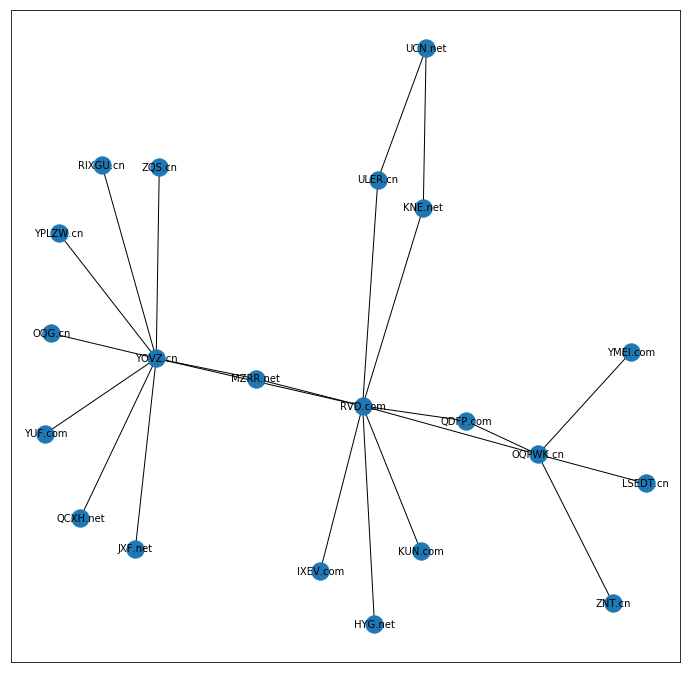

In [157]:
def genearte_random_website():
    return ''.join([random.choice(ascii_uppercase) for _ in range(random.randint(3, 5))]) + '.'  + random.choice(['com', 'cn', 'net'])

websites = [genearte_random_website() for _ in range(25)]

website_connection = {
    websites[0]: random.sample(websites, 10),
    websites[1]: random.sample(websites, 5),
    websites[3]: random.sample(websites, 7),
    websites[4]: random.sample(websites, 2),
    websites[5]: random.sample(websites, 1),
}

website_network = nx.graph.Graph(website_connection)

plt.figure(3,figsize=(12,12))
nx.draw_networkx(website_network, font_size=10)

fatal: cannot do a partial commit during a merge.
